<div>
    <div style="text-align: right;"><span style="font-size: 24px;"><strong>Stephanie Dragoi, Steven Xu</strong></span></div> <br>
    <div style="text-align: right;"><span style="font-size: 24px;"><strong>Due 20240104 THU </strong></span></div> <br>
</div>


# <p style="text-align:center;">Project 4: ROC AUC Enhancement</p>

In [2]:
# import necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
 accuracy_score,
 recall_score,
 precision_score,
 f1_score,
 confusion_matrix,
 roc_auc_score,
 roc_curve
)


# Step 1: Create the dataframe

In [3]:
df = pd.read_csv("loan_database.csv")
df

,loan_type,loan_amount_index,previous_defaults,previous_nondefaults,previous_loan_count,cars_in_household,other_vehicles_owned,adults_in_household,children_in_household,market_segment_code,issues_needing_resolution,hmc,application_year,application_month,application_in_first_half_of_month,loan_origination,repeat_customer,mystery_field,loan_default
0,auto,134,0,0,0,1,3,3,0,ms498,0,0,2022,2,0,website,0,32,0
1,auto,118,0,0,0,0,1,2,1,ms818,2,0,2022,2,0,website,0,15,0
2,other,86,0,0,0,0,3,1,0,ms818,1,0,2021,3,1,website,0,121,0
3,auto,131,0,0,0,2,1,2,1,ms818,1,0,2021,12,1,website,0,171,1
4,auto,145,0,0,0,2,4,3,0,ms818,0,0,2022,7,0,website,0,209,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42197,auto,88,0,0,0,4,5,2,0,ms818,2,0,2021,4,0,website,0,80,0
42198,auto,160,0,0,0,0,3,2,1,ms818,2,0,2022,6,1,website,0,57,0
42199,auto,94,0,0,0,1,4,2,0,ms818,1,0,2021,10,1,website,0,28,0
42200,auto,184,0,0,0,1,2,3,0,ms604,1,0,2021,1,0,website,0,47,0


# Step 2: Understand the context

Our team is made up of data scentists for the consumer loan division of HansenBank. The objective of this project is to build a predictive logistic regression model that is useful for classifying loans as "not default" or "default". We also hope to accomplish four subtasks in support of this objective:
* To analyze the data provided
* To find which factors have a good ability to predict loan default
* To build a predictive model that can predict which loans are likely to go into default
* To suggest profitable policies for determining loan approval criteria.

We wish to predict whether loan applications are likely to result in performing or nonperforming loans in order to maximize profitability. Approving performing loans will allow HansenBank to make a profit, since the customer will make payments on time and pay an interest rate that is higher than the rate the bank itself has to pay to acquire the money for the loan. Avoiding nonperforming loans will prevent the bank from losing money. Customers who don't make payments on time or default on the loan altogether will force the bank to use time and money to pressure the customer and to recover collateral.

Given the null hypothesis of "situation normal/performing loan" in the context of this project, a Type I error occurs if the bank incorrectly rejects the null hypothesis even though the loan would have become performing. A Type II error occurs if the bank fails to reject the null hypothesis and approves the loan even though the loan will ultimately become nonperforming. We conclude that though Type I and Type II error are similar in the net loss they may incur, Type II errors are marginally worse. Type I errors would result in a loss of money due to the cost of defending against a lawsuit, which certainly would not occur in all cases of such errors. We do not consider failure to earn money that could have hypothetically been earned in the absence of such an error as a loss. Type II errors, however, always carry with them the cost of losing the loan and recovering collateral. 

Based on our decision that both types of errors are equally severe, we will most likely emphasize accuracy and recall as performance metrics, but will also consider the F1 statistic. Accuracy will measure the overall correctness of the model, recall will measure the model's performance on predicting the positive class, and F1 will recognize the tradeoff between recall and precision, or of avoiding Type II or Type I errors.

We have just described the context, objectives, significance, and rough roadmap for this project.

# Step 3: Data dictionary

* <b>loan_type</b>: auto, residential, or other
* <b>loan_amount_index</b>: 100 = national median for loan type, other quantities prorated
accordingly
* <b>previous_defaults</b>: number of times this customer has previously defaulted
* <b>previous_nondefaults</b>: number of times this customer has previously held a performing
loan (possibly still in progress)
* <b>previous_loan_count</b>: number of previous loans issued to this customer
* <b>cars_in_household</b>: number of passenger vehicles in customer's household
* <b>other_vehicles_owned</b>: number of other vehicles (boats, motorcycles, etc.) titled to the
customer
* <b>adults_in_household</b>: number of adults age 18+ in customer's household
* <b>children_in_household</b>: number of children under age 18 in customer's household
* <b>market_segment_code</b>: proprietary code for customer's market segment
* <b>issues_needing_resolution</b>: number of paperwork issues requiring special attention on
the application
* <b>hmc</b>: 1 = high maintenance customer, 0 = normal customer with no special handling needed
* <b>application_year</b>: YYYY format
* <b>application_month</b>: 1 (January) through 12 (December)
* <b>application_in_first_half_of_month</b>: 1 = application filed on day 1-15 of month, 0 =
filed any other day of month
* <b>loan_origination</b>: website, bank branch, or other
* <b>repeat_customer</b>: 1 = customer has previously been a loan customer, 0 = no previous loan
* <b>mystery_field</b>: no information
* <b>loan_default</b>: 1 = this loan ended in default, 0 = performing loan (either paid off or
in progress)

We have just created a data dictionary to allow anyone who reads this notebook to understand the meaning of each field.

# Step 4: Useful Python functions

In [4]:
# Custom code written 20210625 FRI by E. M. Hansen
# This code is a modified and simplified version of the
# histogram_boxplot custom function written by someone else.

def boxpl_and_hist(data_series): # Display a boxplot above a histogram.
# (NOTE: this code is a modified
# version of the histogram_boxplot
# custom function written by someone
# else.)
 scratch_vbl, (box1, hist1) = plt.subplots(nrows=2, # Set up combined plot with 2 rows.
 figsize=(16,8),
sharex=True, # Both plots should use same x-axis.
gridspec_kw = {"height_ratios": (.1, .9)})
 # Note: scratch_vbl must be present for code to work. Not sure
# what its purpose is, since the variable is never needed or
# used again.
 sns.boxplot(x=data_series, ax=box1, showmeans=True, color='cyan') # triangle for mean
 sns.histplot(x=data_series, ax=hist1, kde=False, color='cyan') # histplot, not distplot
 hist1.axvline(np.mean(data_series), color='green', linestyle='--') # mean (dotted)
 hist1.axvline(np.median(data_series), color='magenta', linestyle='-') # median (solid)
 plt.show() # Display both plots.

In [5]:
# Function to return a dataframe showing the VIF for each explanatory variable:
# Note that the explanatory variables are in a dataframe called Xdataframe.

def calculate_vif(Xdataframe):
 temp_df = pd.DataFrame()
 temp_df["column name"] = Xdataframe.columns
 temp_df["VIF"] = [variance_inflation_factor(Xdataframe.values, k)
 for k in range(len(Xdataframe.columns))]
 return temp_df

In [6]:
def confusion_matrix_statsmodels(model, predictors, target, threshold=0.5):
 y_pred = model.predict(predictors) > threshold
 cm = confusion_matrix(target, y_pred)
 labels = np.asarray(
 [
 ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
 for item in cm.flatten()
 ]
 ).reshape(2, 2)
 plt.figure(figsize=(6, 4))
 sns.heatmap(cm, annot=labels, fmt="")
 plt.ylabel("True value of target")
 plt.xlabel("Predicted value of target")

In [7]:
def model_performance_classification_statsmodels(model, predictors, target, threshold=0.5):
 # checking which probabilities are greater than threshold
 pred_temp = model.predict(predictors) > threshold
 # rounding off the above values to get classes
 pred = np.round(pred_temp)
 acc = accuracy_score(target, pred) # compute Accuracy
 recall = recall_score(target, pred) # compute Recall
 precision = precision_score(target, pred) # compute Precision
 f1 = f1_score(target, pred) # compute F1
 # creating a dataframe of metrics
 df_perf = pd.DataFrame(
 {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,}, index=[0])
 return df_perf

In [8]:
def bargraph_with_labels(data, feature, perc=False, n=None): # author unknown
 # data = placeholder for dataframe (df)
# feature = column to graph
# perc = display %s instead of counts
# n = number of category levels to show
 total = len(data[feature])
 count = data[feature].nunique()
 if n is None:
     plt.figure(figsize=(count + 2, 6))
 else:
     plt.figure(figsize=(n + 2, 6))
 plt.xticks(rotation=90, fontsize=12)
 ax = sns.countplot(
 data=data,
 x=feature,
 palette="Paired",
 order=data[feature].value_counts().index[:n].sort_values(),
 )
 for p in ax.patches:
     if perc == True:
         label = "{:.1f}%".format(
         100 * p.get_height() / total
         )
     else:
         label = p.get_height()
     x = p.get_x() + p.get_width() / 2 # width of plot
     y = p.get_height() # height of plot
     ax.annotate(
     label,
     (x, y),
     ha="center",
     va="center",
     size=12,
     xytext=(0, 5),
     textcoords="offset points",
     )
 plt.show()

In [9]:
def plot_categorical_vs_target(data, feature, target_vbl_name):
 x,y = feature, target_vbl_name
 for feature in [data]:
        (feature
 .groupby(x)[y]
 .value_counts(normalize=True)
 .mul(100)
 .rename('percent')
 .reset_index()
 .pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar'))
 plt.show()


In [10]:
def boxplots_vs_target(data, feature, target_vbl_name):
 figsize=(12, 10)
 sns.boxplot(data=data, x=target_vbl_name, y=feature, palette="gist_rainbow")
 plt.show()

We have just defined some useful Python functions.

# Step 5: Drop duplicate rows

In [11]:
df[df.duplicated()].count()

loan_type                             1947
loan_amount_index                     1947
previous_defaults                     1947
previous_nondefaults                  1947
previous_loan_count                   1947
cars_in_household                     1947
other_vehicles_owned                  1947
adults_in_household                   1947
children_in_household                 1947
market_segment_code                   1947
issues_needing_resolution             1947
hmc                                   1947
application_year                      1947
application_month                     1947
application_in_first_half_of_month    1947
loan_origination                      1947
repeat_customer                       1947
mystery_field                         1947
loan_default                          1947
dtype: int64

In [12]:
df.drop_duplicates(inplace=True)
df.shape[0]

40255

We have just dropped any duplicate rows. Since 1,947 subtracted from the original number of rows, 42,202, equals 40,255, the counts are correct.

# Step 6: Look for missing values

In [13]:
df.isnull().sum()

loan_type                             0
loan_amount_index                     0
previous_defaults                     0
previous_nondefaults                  0
previous_loan_count                   0
cars_in_household                     0
other_vehicles_owned                  0
adults_in_household                   0
children_in_household                 0
market_segment_code                   0
issues_needing_resolution             0
hmc                                   0
application_year                      0
application_month                     0
application_in_first_half_of_month    0
loan_origination                      0
repeat_customer                       0
mystery_field                         0
loan_default                          0
dtype: int64

We have checked for any missing or null values. Since the sums are all 0, there are no missing values.

# Step 7: Display summary statistics

In [14]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
loan_amount_index,40255.0,106.992001,38.746823,0.0,81.0,100.0,128.0,376.0
previous_defaults,40255.0,0.027475,0.363116,0.0,0.0,0.0,0.0,11.0
previous_nondefaults,40255.0,0.235126,2.293531,0.0,0.0,0.0,0.0,72.0
previous_loan_count,40255.0,0.262601,2.523291,0.0,0.0,0.0,0.0,78.0
cars_in_household,40255.0,0.834157,0.861774,0.0,0.0,1.0,2.0,7.0
other_vehicles_owned,40255.0,2.200944,1.395875,0.0,1.0,2.0,3.0,17.0
adults_in_household,40255.0,1.861533,0.525784,0.0,2.0,2.0,2.0,4.0
children_in_household,40255.0,0.105651,0.395912,0.0,0.0,0.0,0.0,10.0
issues_needing_resolution,40255.0,0.779332,0.856337,0.0,0.0,1.0,1.0,5.0
hmc,40255.0,0.033809,0.180741,0.0,0.0,0.0,0.0,1.0


We have displayed the summary statistics for the dataframe. The fields with suspiciously low "min" values are
* loan_amount_index with 0
* adults_in_household with 0

However, the fields with suspiciously high "max" values are
* previous_defaults with 11
* previous_nondefaults with 72
* previous_loan_count with 78
* cars_in_household with 7
* other_vehicles_owned with 17
* children_in_household with 10.

# Step 8: Display boxplot and histogram for loan_amount_index field

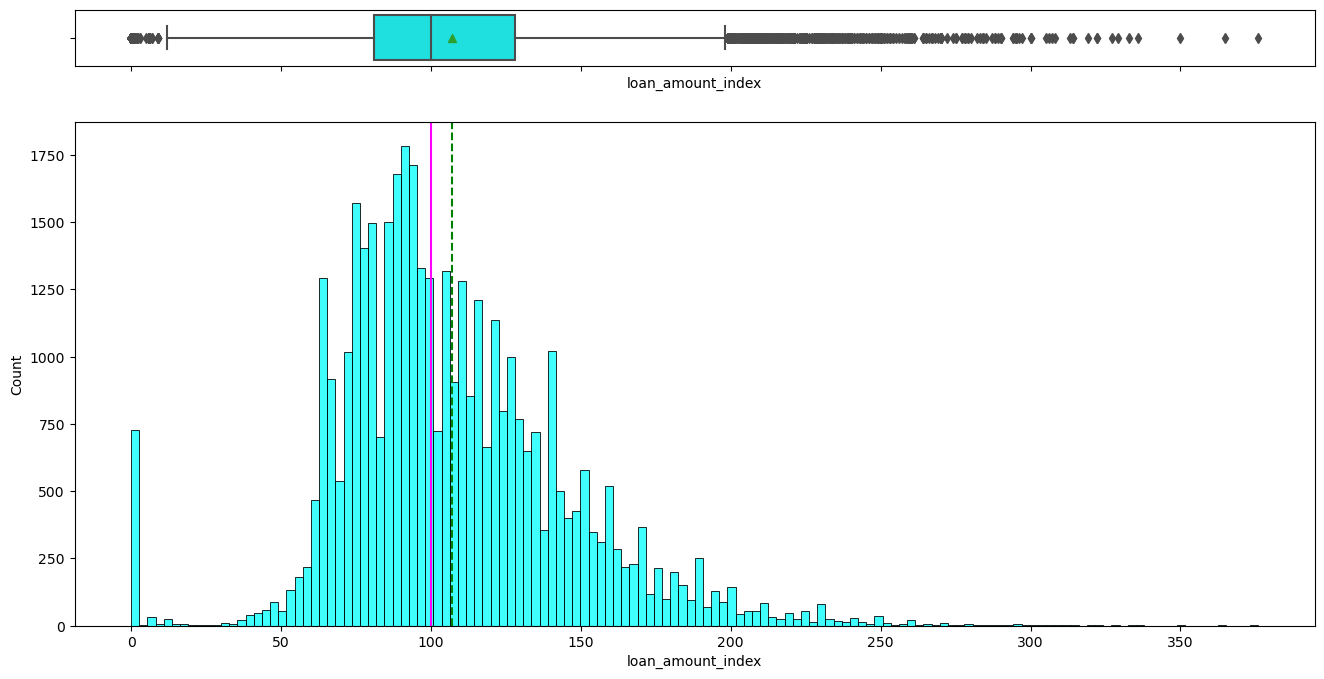

In [15]:
boxpl_and_hist(df["loan_amount_index"])

We have displayed the boxplot and histogram for the loan_amount_index_field. There is some right-skewness. There is also a good number of samples with a loan amount index of 0.

# Step 9: Drop records for which loan_amount_index is 0

In [16]:
# new df only for records where loan_amount_index = 0
filtered_df = df[df['loan_amount_index'] == 0]
result_df = pd.concat([filtered_df.head(), filtered_df.tail()])

# displaying first 5 and last 5 records
result_df

,loan_type,loan_amount_index,previous_defaults,previous_nondefaults,previous_loan_count,cars_in_household,other_vehicles_owned,adults_in_household,children_in_household,market_segment_code,issues_needing_resolution,hmc,application_year,application_month,application_in_first_half_of_month,loan_origination,repeat_customer,mystery_field,loan_default
132,auto,0,0,0,0,2,3,1,0,ms818,0,0,2020,7,0,website,0,210,0
149,other,0,0,0,0,2,1,2,0,ms818,1,0,2022,5,0,website,0,22,0
195,auto,0,0,0,0,0,2,2,0,ms818,1,0,2022,3,1,other,0,41,0
196,auto,0,3,13,16,0,2,1,0,ms296,1,0,2021,7,1,other,1,23,0
257,auto,0,0,0,0,2,0,1,0,ms818,0,0,2021,1,0,other,0,24,0
41691,auto,0,0,12,12,0,1,1,0,ms818,1,0,2022,5,0,other,1,36,0
41790,auto,0,0,0,0,0,1,2,0,ms818,1,0,2020,11,0,other,0,14,0
41858,auto,0,0,0,0,2,0,1,0,ms818,0,0,2021,3,1,other,0,15,0
41905,auto,0,0,0,0,0,1,2,0,ms498,1,0,2022,2,0,other,0,6,0
42001,auto,0,0,0,0,0,1,1,0,ms818,3,0,2021,5,0,other,0,9,0


In [17]:
df.drop(df[df['loan_amount_index'] == 0].index, inplace=True)

# display number of rows
df.shape[0]

39546

We have dropped the records in which the loan_amount_index field equals 0. The record count of 39,546 is correct since 709 subtracted from 40,255 is equal to 39,546.

It makes sense to drop those 709 records because they are not representative of the broader distribution of the field. In the histogram, most of the field values are clustered between the values of 50 and 200. 

# Step 10: Convert categorical variables to true categories

In [18]:
df['loan_type'] = df['loan_type'].astype('category')
df['market_segment_code'] = df['market_segment_code'].astype('category')
df['loan_origination'] = df['loan_origination'].astype('category')

In [19]:
df['application_year'] = pd.Categorical(df['application_year'], ordered=True)
df['application_month'] = pd.Categorical(df['application_month'], ordered=True)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39546 entries, 0 to 42201
Data columns (total 19 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   loan_type                           39546 non-null  category
 1   loan_amount_index                   39546 non-null  int64   
 2   previous_defaults                   39546 non-null  int64   
 3   previous_nondefaults                39546 non-null  int64   
 4   previous_loan_count                 39546 non-null  int64   
 5   cars_in_household                   39546 non-null  int64   
 6   other_vehicles_owned                39546 non-null  int64   
 7   adults_in_household                 39546 non-null  int64   
 8   children_in_household               39546 non-null  int64   
 9   market_segment_code                 39546 non-null  category
 10  issues_needing_resolution           39546 non-null  int64   
 11  hmc                         

We have just converted the the fields loan_type, market_segment_code, loan_origination, application_year, and application_month into categorical variables. 

We do not need to do the same thing for the hmc, application_in_first_half_if_month, repeat_customer, and loan_default variables because they are booleans. They need to be one-hot encoded and they already are, since all the values are either 1 or 0. 



# Step 11: Test for imbalance in target variable

In [21]:
print("Percentage of 1 values in target variable: ", (df['loan_default'].sum()/df['loan_default'].count())*100)
print("Percentage of 0 values in target variable: ", (1-(df['loan_default'].sum()/df['loan_default'].count()))*100)

Percentage of 1 values in target variable:  16.59586304556719
Percentage of 0 values in target variable:  83.4041369544328


The target variable is quite imbalanced, with a 0:1 split of about 83/16. This is not surprising, since one would expect the majority of customers not to default on loans, but this skewnes in the data may affect the model performance depending on the results of our EDA.

We have just examined the 0:1 split in the target variable.

# Step 12: Exploratory data analysis (EDA) for application_month

<Axes: xlabel='application_month', ylabel='count'>

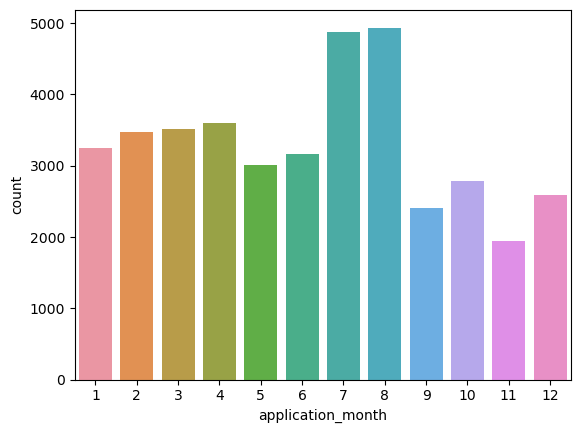

In [22]:
sns.countplot(x='application_month', data=df)

July and August seem to be the most popular months for applying for loans.

In [23]:
pd.crosstab(df['application_month'], df['application_year'], dropna=False)

application_year,2020,2021,2022
application_month,,,
1,0,1932,1312
2,0,2139,1329
3,0,1687,1825
4,0,1737,1855
5,0,916,2095
6,0,1297,1873
7,1310,1827,1737
8,1444,1951,1542
9,553,1858,0


Counting the number of applications by month does not explain which months are the most popular for applying for loans because there is no data for the first 6 months of 2020 and the last 4 months of 2022. As a result, July and August, the months that have data for all 3 years, will seem to be the most popular month based solely on this data file.

In [24]:
plot_df = pd.DataFrame([[1,0],[2],[3],[4],[5],[6],[7],[8],[9],[10],[11],[12]])
ctab=pd.crosstab(df['application_month'], df['application_year'], dropna=False)
grandtotal = 0
for i in range (ctab.shape[0]):
 month = ctab.index[i]
 rowtotal = 0
 num_of_nonzeros = 0 # counter for number of nonzero month values in crosstab table
 for j in range (3):
     rowtotal = rowtotal + ctab.iloc[i,j]
     if ctab.iloc[i,j] > 0:
         num_of_nonzeros = num_of_nonzeros + 1
 print('Month',month,
     ': total # of records =',rowtotal,
     'for',num_of_nonzeros,
     'years (mean = ', (rowtotal/num_of_nonzeros),')')
 plot_df.iloc[i,1] = rowtotal/num_of_nonzeros
 grandtotal = grandtotal + rowtotal
print('\nGrand total for all records =',grandtotal)
plot_df.columns = ['Month (1=Jan)','Mean Number of Applications']
plot_df # Display dataframe that stores the mean number of records for each month.


Month 1 : total # of records = 3244 for 2 years (mean =  1622.0 )
Month 2 : total # of records = 3468 for 2 years (mean =  1734.0 )
Month 3 : total # of records = 3512 for 2 years (mean =  1756.0 )
Month 4 : total # of records = 3592 for 2 years (mean =  1796.0 )
Month 5 : total # of records = 3011 for 2 years (mean =  1505.5 )
Month 6 : total # of records = 3170 for 2 years (mean =  1585.0 )
Month 7 : total # of records = 4874 for 3 years (mean =  1624.6666666666667 )
Month 8 : total # of records = 4937 for 3 years (mean =  1645.6666666666667 )
Month 9 : total # of records = 2411 for 2 years (mean =  1205.5 )
Month 10 : total # of records = 2790 for 2 years (mean =  1395.0 )
Month 11 : total # of records = 1942 for 2 years (mean =  971.0 )
Month 12 : total # of records = 2595 for 2 years (mean =  1297.5 )

Grand total for all records = 39546


,Month (1=Jan),Mean Number of Applications
0,1,1622.000000
1,2,1734.000000
2,3,1756.000000
3,4,1796.000000
4,5,1505.500000
5,6,1585.000000
6,7,1624.666667
7,8,1645.666667
8,9,1205.500000
9,10,1395.000000


April has the highest mean number of applications.

<Axes: xlabel='Month (1=Jan)', ylabel='Mean Number of Applications'>

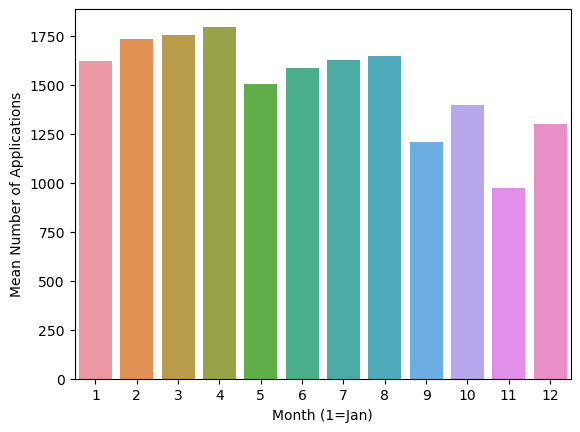

In [25]:
sns.barplot(x=plot_df['Month (1=Jan)'], y=plot_df['Mean Number of Applications'], data=plot_df)


We have just done EDA on the application_month field to determine which month is the most popular for loan applications.

# Step 13: Univariate EDA of each categorical variable

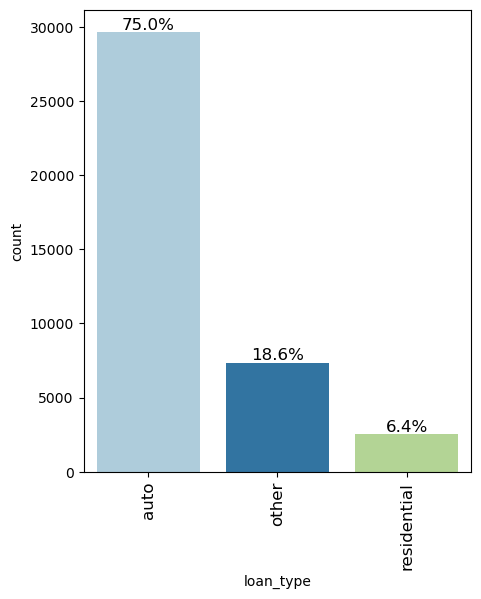

In [26]:
bargraph_with_labels(df, 'loan_type', perc=True)
plt.show()

Three quarters of loan customers are auto loan customers, while the smallest proportion, a bit over 5%, are residential loan customers.

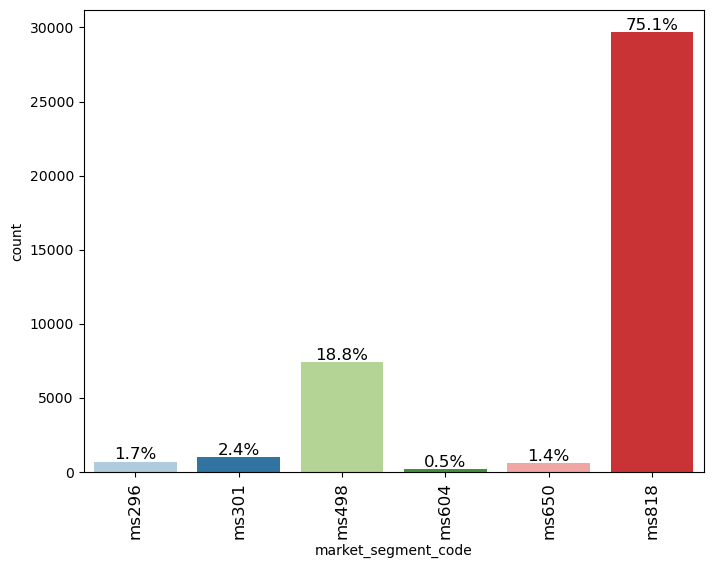

In [27]:
bargraph_with_labels(df, 'market_segment_code', perc=True)
plt.show()

The large majority of loan seekers come from the market segment ms818, while the fewest come from ms296, ms301, ms604, and ms650.

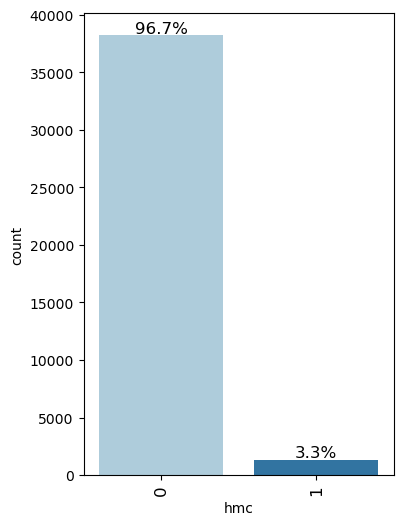

In [28]:
bargraph_with_labels(df, 'hmc', perc=True)
plt.show()

The vast majority of loans, almost 100%, are HMC, or high maintenance customers.

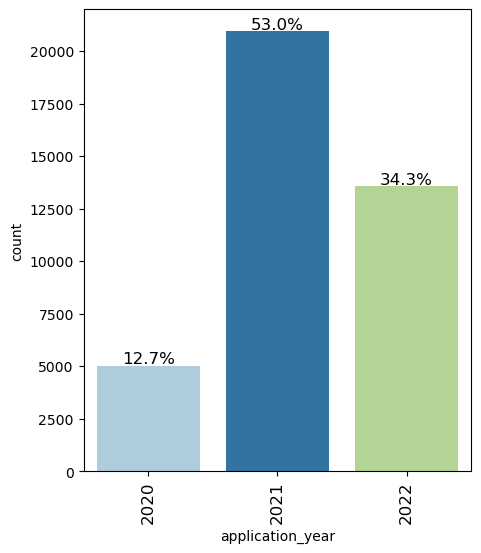

In [29]:
bargraph_with_labels(df, 'application_year', perc=True)
plt.show()

The fewest number of loan applications were made in 2020, likely due to the fact that 2020 does not have data for the first 6 months and 2022 does not have data for the last 4 months.

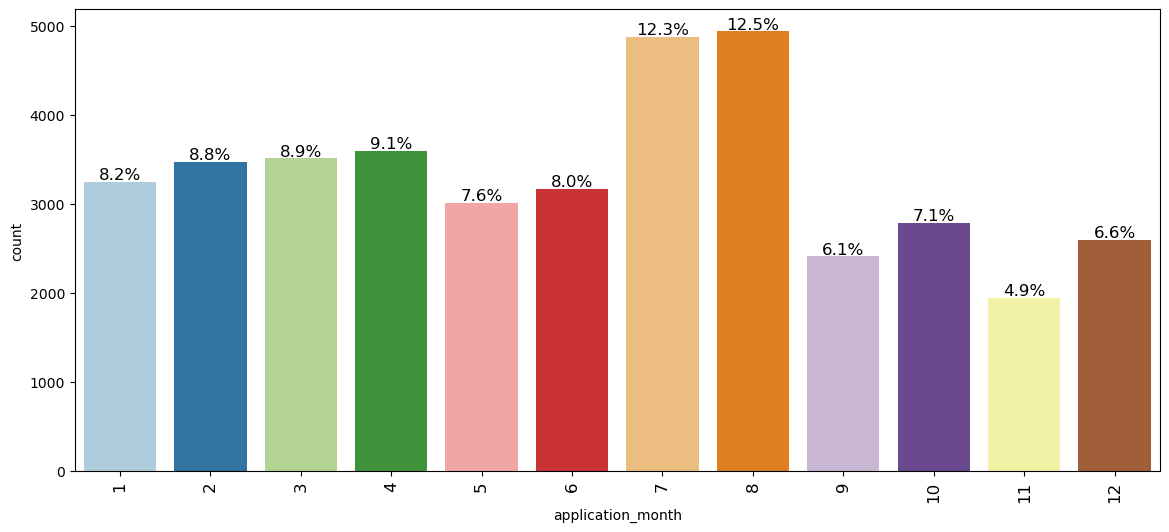

In [30]:
bargraph_with_labels(df, 'application_month', perc=True)
plt.show()

The largest proportion of loans were made in July and August, due to the fact that these two months are the only months with data for all three years. The largest dip in number of loans occurs between August and September with a decrease from 12.5% to 6.1%.

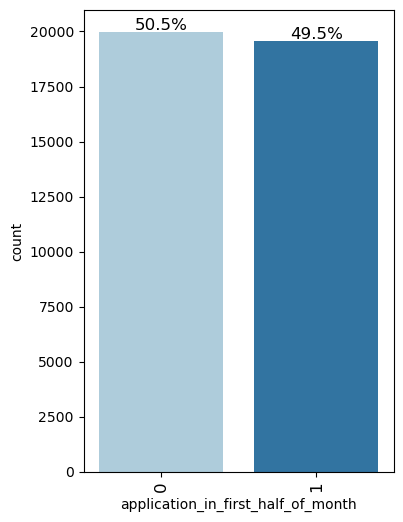

In [31]:
bargraph_with_labels(df, 'application_in_first_half_of_month', perc=True)
plt.show()

The number of loan applications in the first half of the month is almost exactly equal to the number of applicants in the second half of the month.

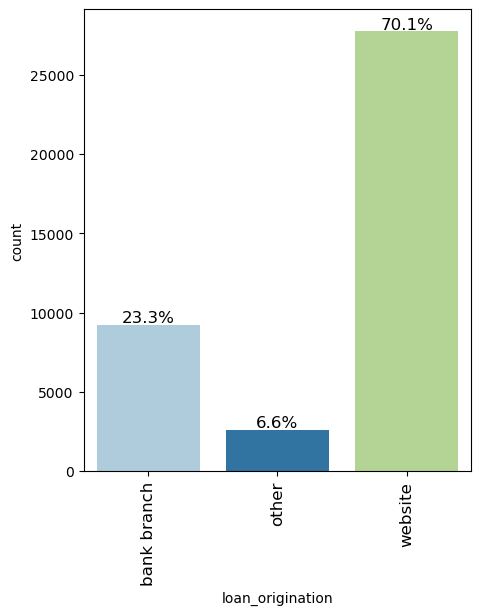

In [32]:
bargraph_with_labels(df, 'loan_origination', perc=True)
plt.show()

The large majority of customers originated their loans on the website, and a good amount-- albeit the smallest number, 6.6%-- chose a method "other" than online or in person at a bank branch.

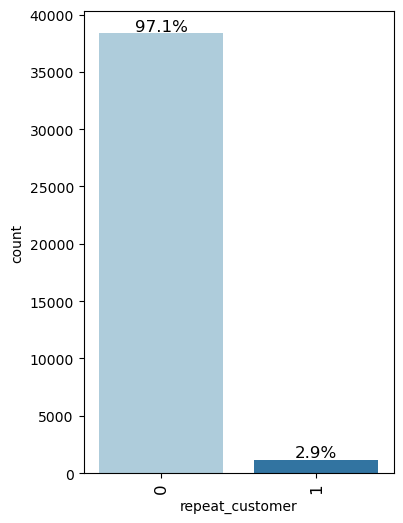

In [33]:
bargraph_with_labels(df, 'repeat_customer', perc=True)
plt.show()

A surprisingly low percentage of customers are repeat customers-- most do not return for another loan.

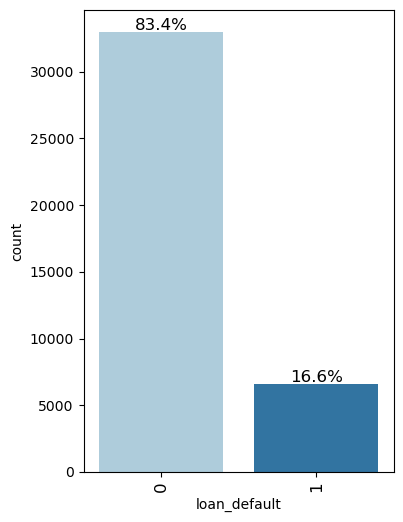

In [34]:
bargraph_with_labels(df, 'loan_default', perc=True)
plt.show()

As we explained in step 11, there is quite a bit of skewness in the target variable split, with there being a bit over five times as many loan payoffs as defaults.

We have just completed univariate exploratory data analysis for our nine categorical variables.

# Step 14: Univariate EDA of each quantitative variable

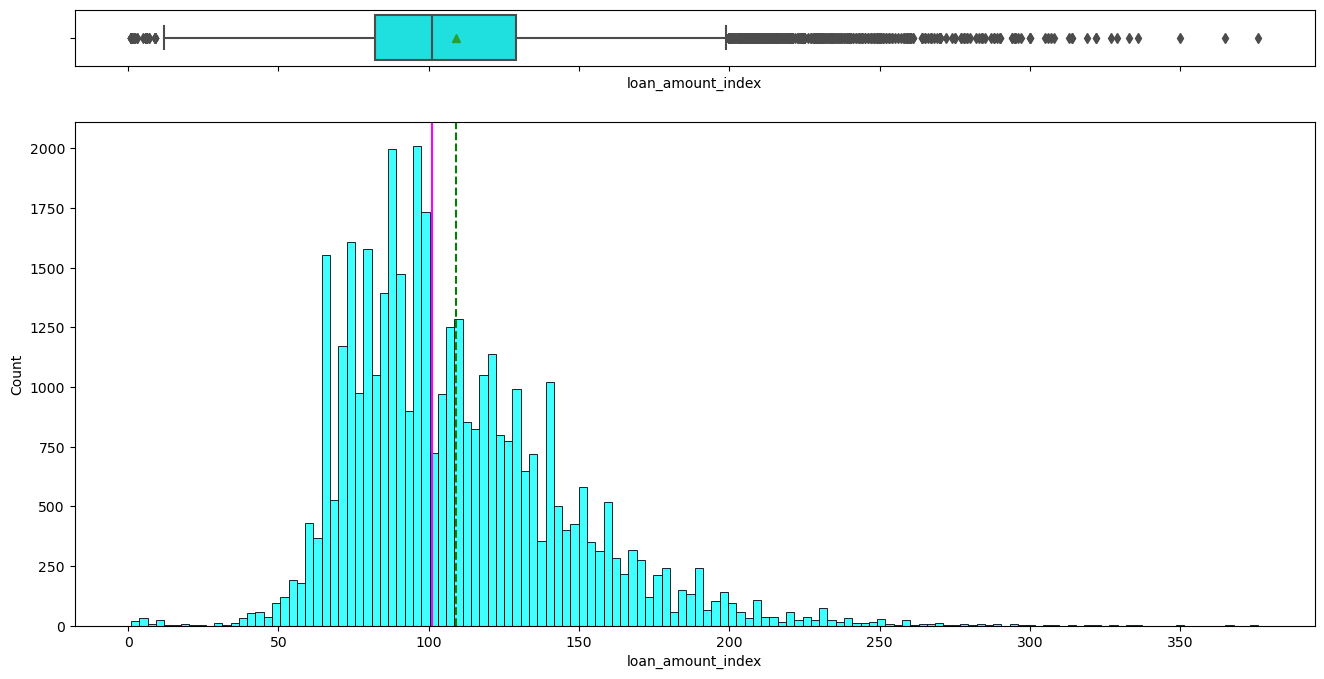

In [35]:
boxpl_and_hist(df["loan_amount_index"])

There is some right skewness in the loan_amount_index field, but most people's index is clustered around 100. 

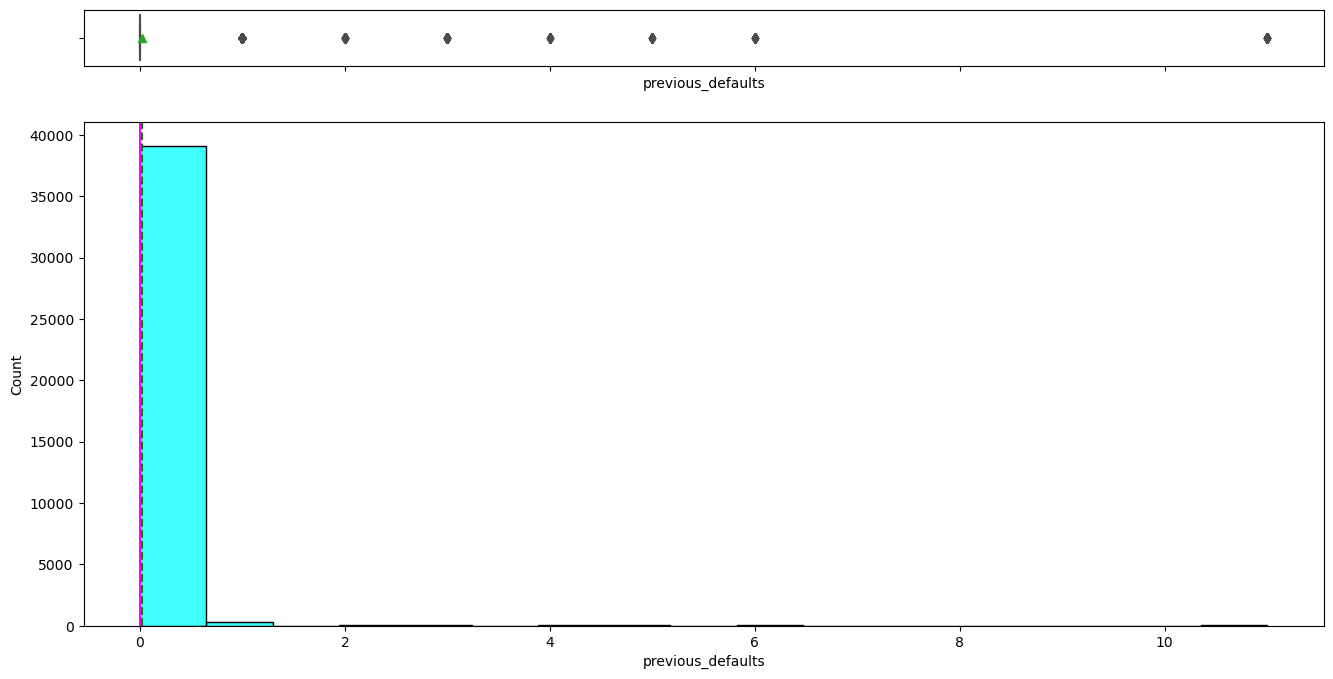

In [36]:
boxpl_and_hist(df["previous_defaults"])

There is extreme right skewness in previous_defaults, since the large majority of people have not even been customers before, let alone applied for or previously defaulted on a loan with the company.

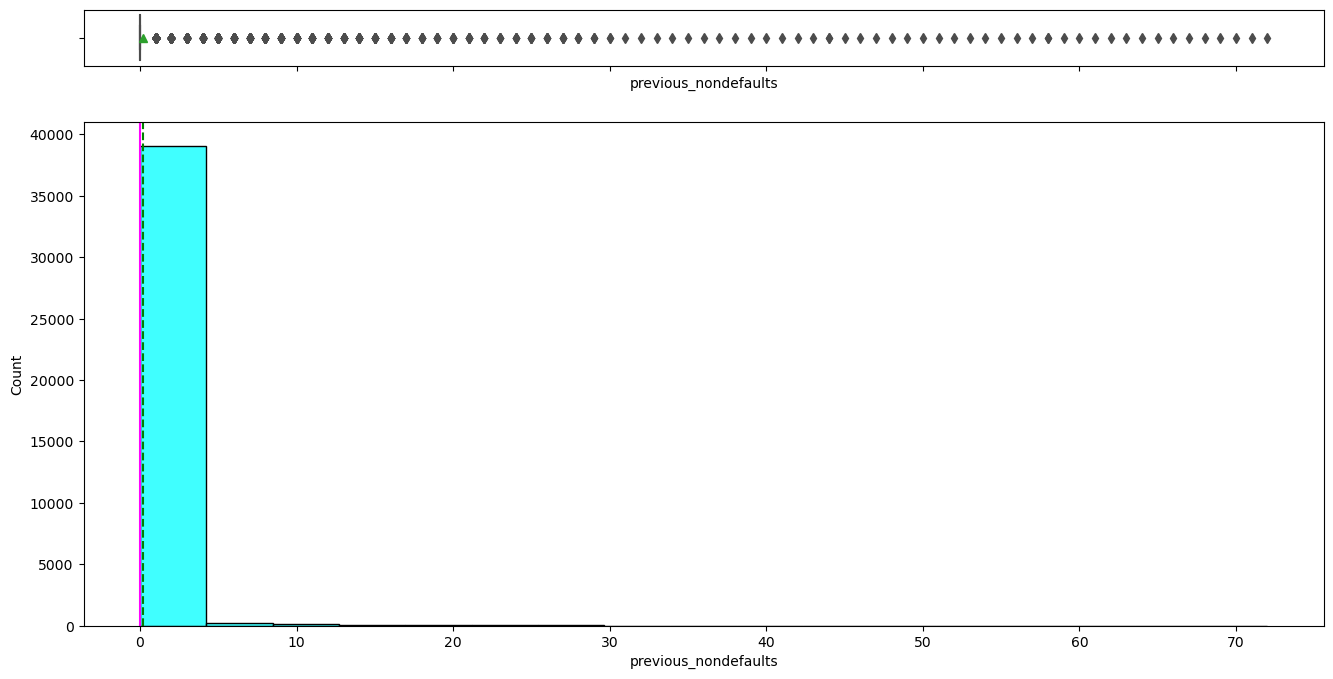

In [37]:
boxpl_and_hist(df["previous_nondefaults"])

Much like the previous_defaults field, this histogram is extremely right skewed. The vast majority of people are applying for a loan for the first time.

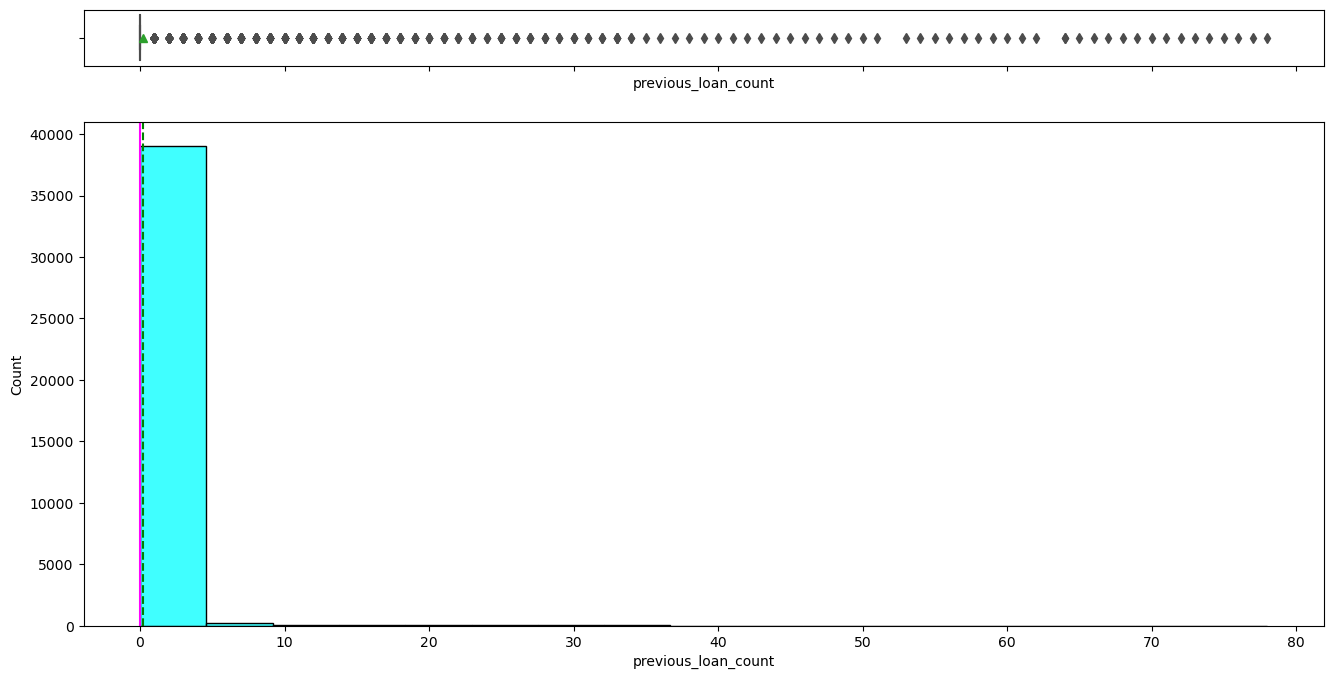

In [38]:
boxpl_and_hist(df["previous_loan_count"])

Much like the previous two histograms, the vast majority of people have not previously applied for a loan.

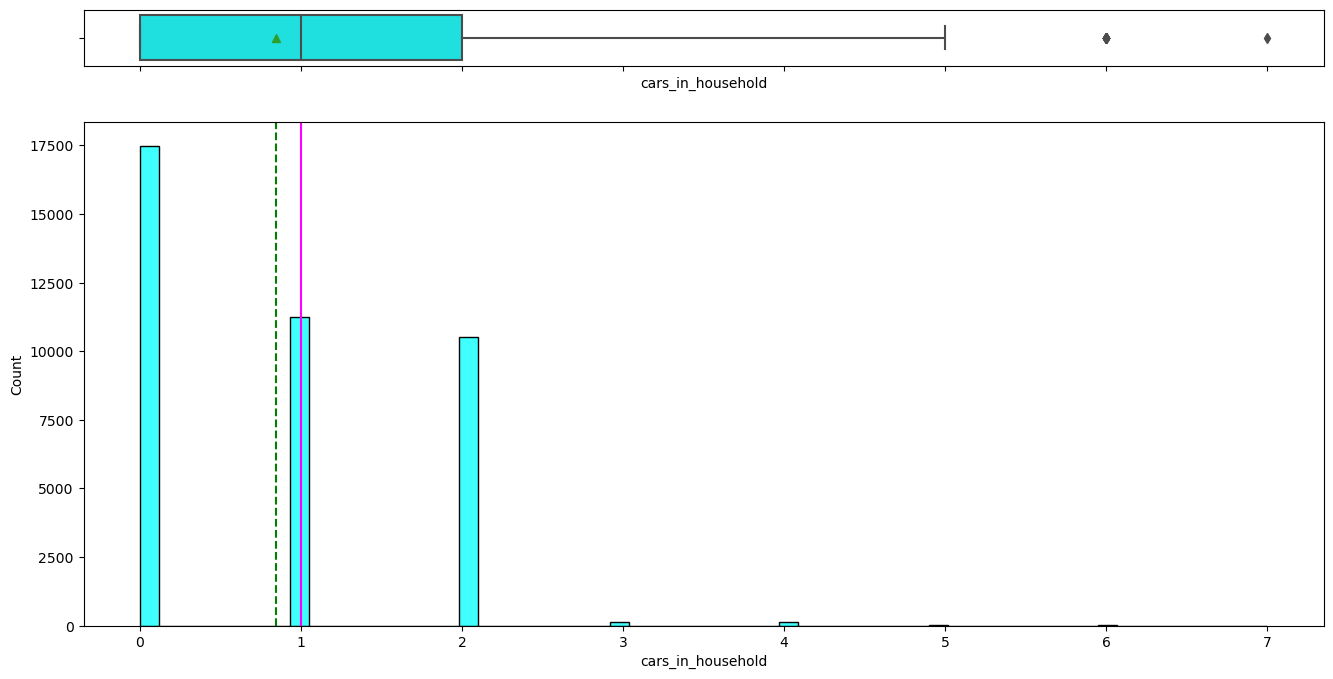

In [39]:
boxpl_and_hist(df["cars_in_household"])

The cars_in_household field is right skewed, with most loan applicants not having more than two cars.

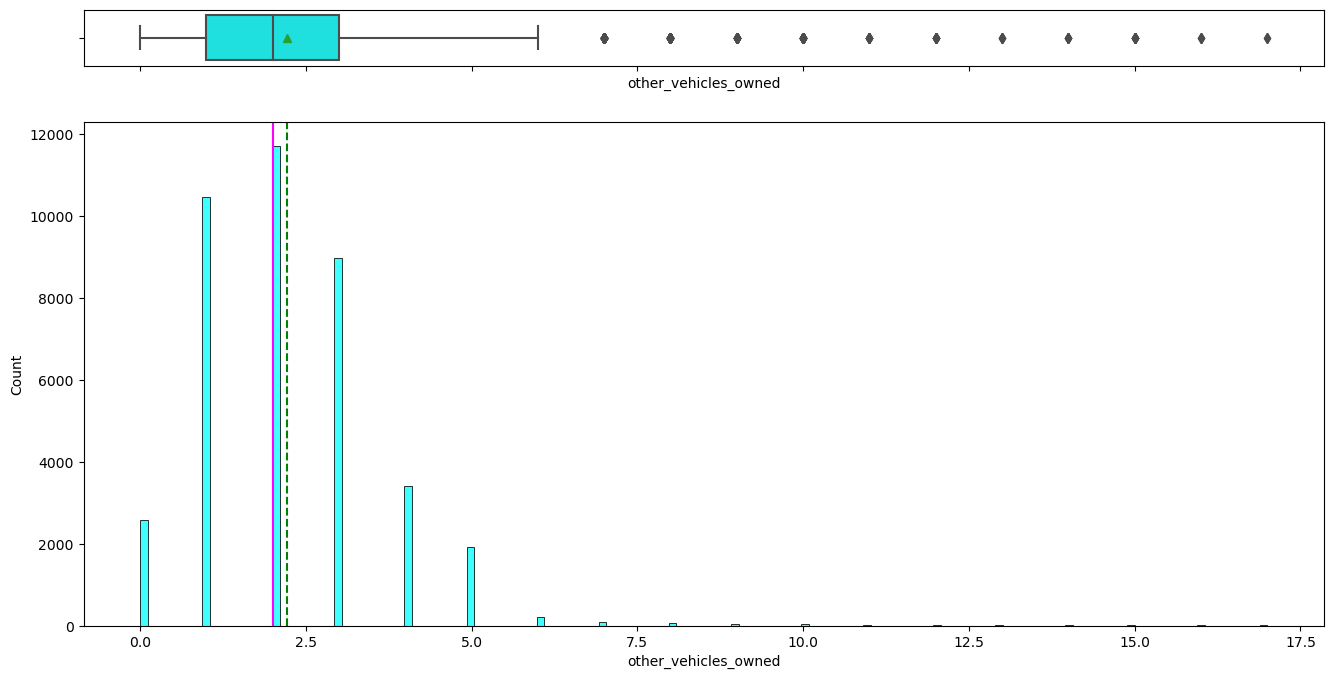

In [40]:
boxpl_and_hist(df["other_vehicles_owned"])

Much like the previous histogram, this histogram is right skewed and most people own no more than 5 vehicles that are not cars.

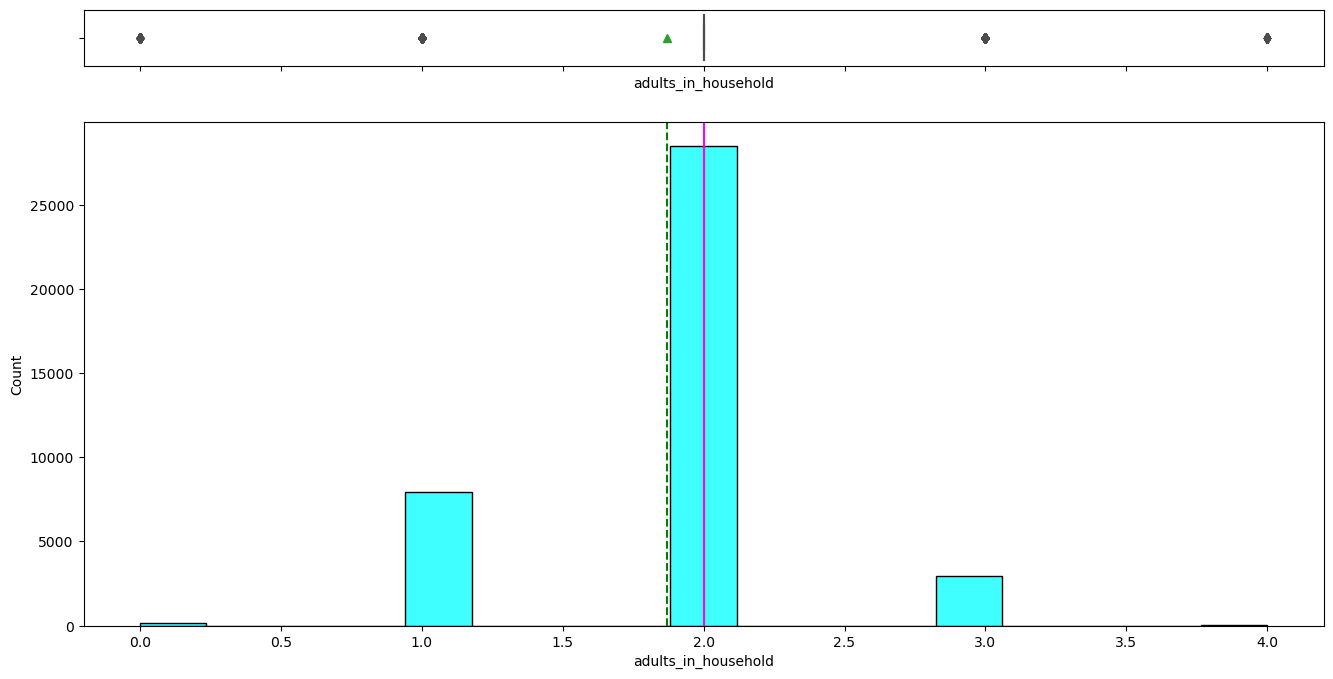

In [41]:
boxpl_and_hist(df["adults_in_household"])

The vast majority of applicants have two adults in their households.

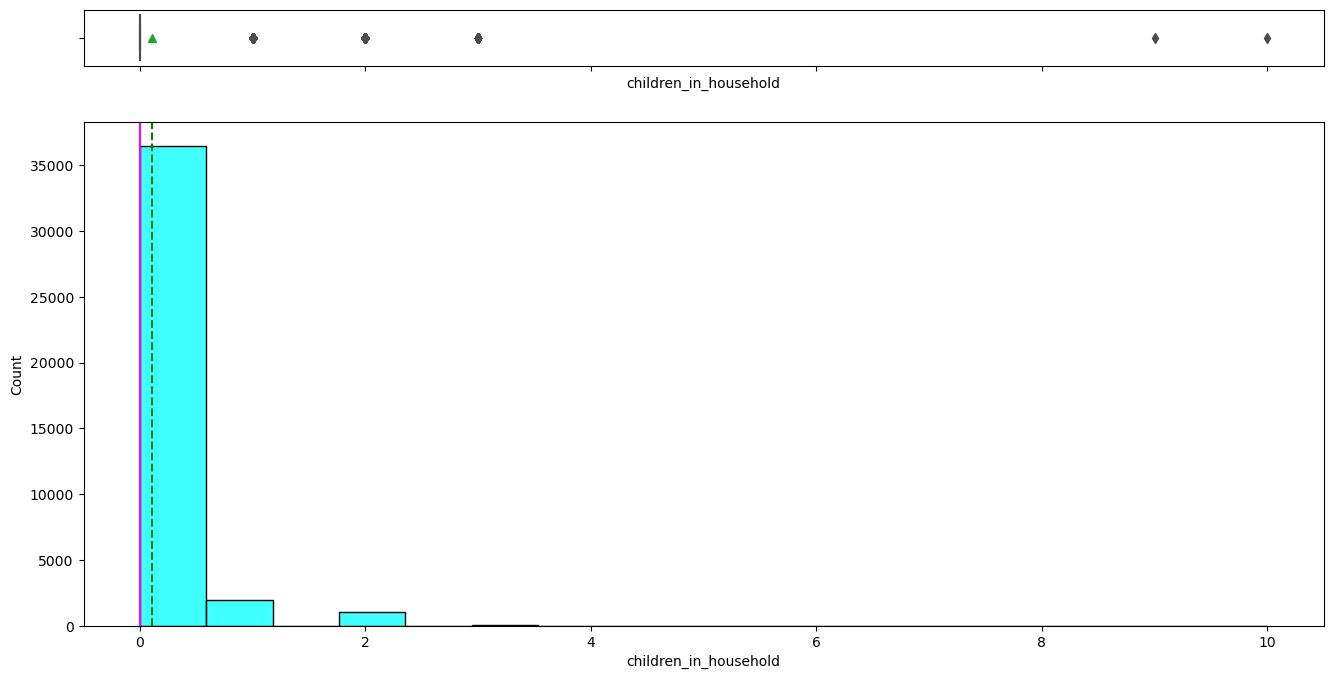

In [42]:
boxpl_and_hist(df["children_in_household"])

The vast majority of loan applicants do not have any children in their household.


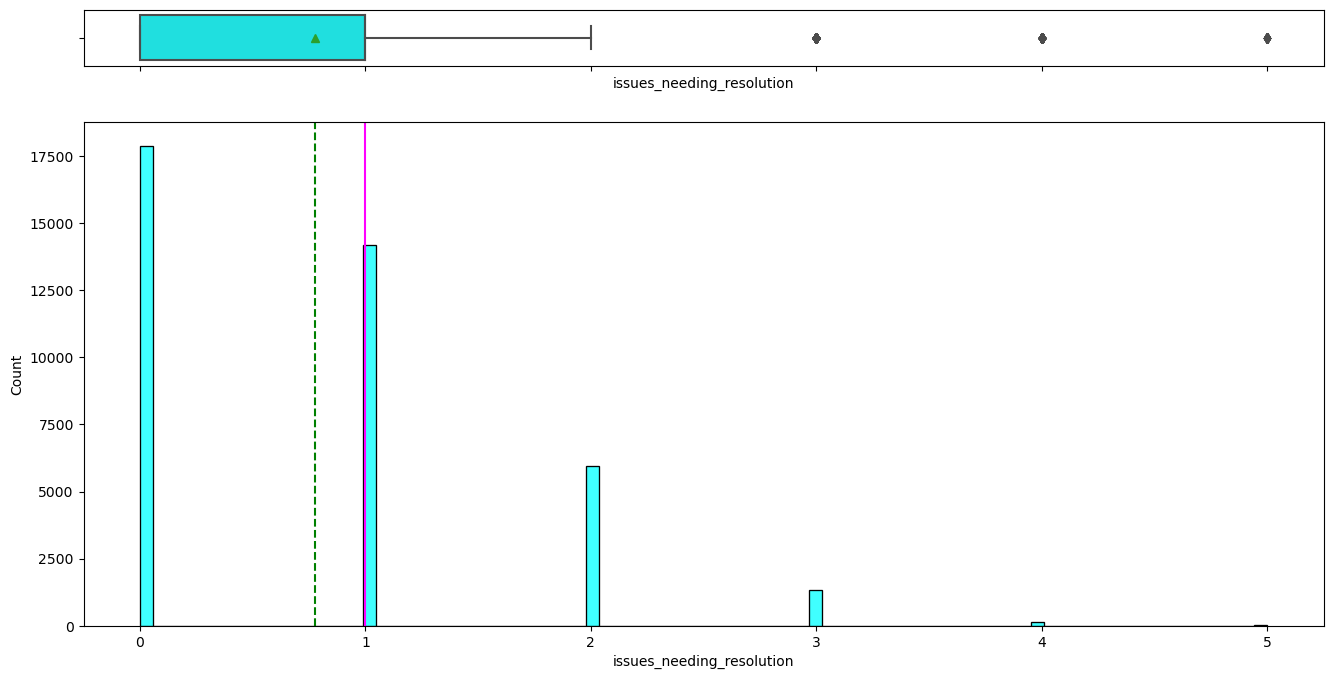

In [43]:
boxpl_and_hist(df["issues_needing_resolution"])

The issues_needing_resolution field is right skewed, since most people have no more than 1 issue that needs to be resolved.

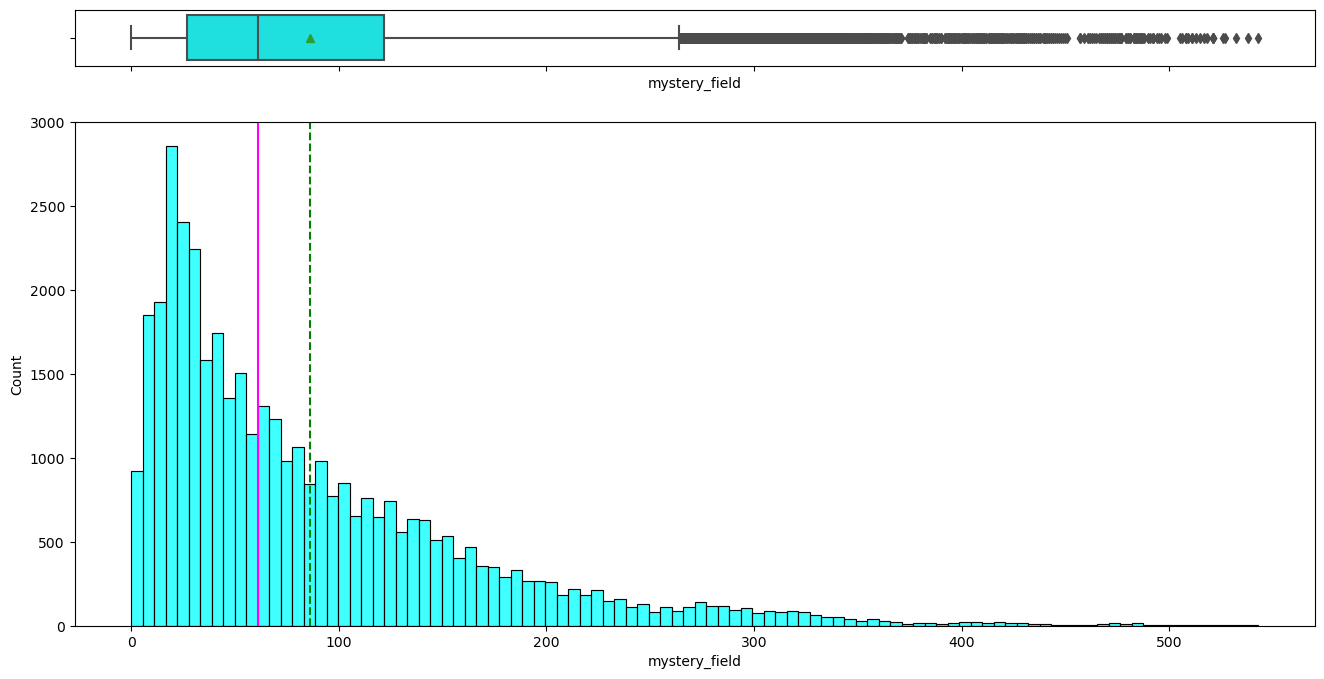

In [44]:
boxpl_and_hist(df["mystery_field"])

This mystery field is very right skewed. Most values lie within the range of 0-200. 

We have just done univariate EDA for each quantitative variable.

# Step 15: Bivariate EDA of each categorical variable with respect to target

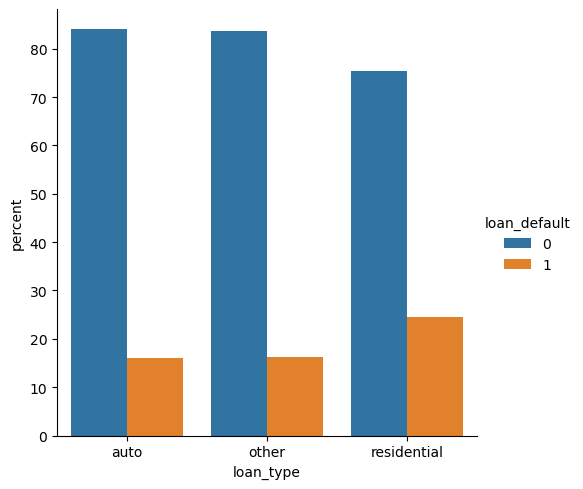

In [45]:
plot_categorical_vs_target(df,'loan_type','loan_default')

### loan_type
Regardless of the loan type, there is roughly an equal proportion of people who did not default on their loans to the ones who did. However, the residential loan types seem to have a slightly higher percentage of defaulters.

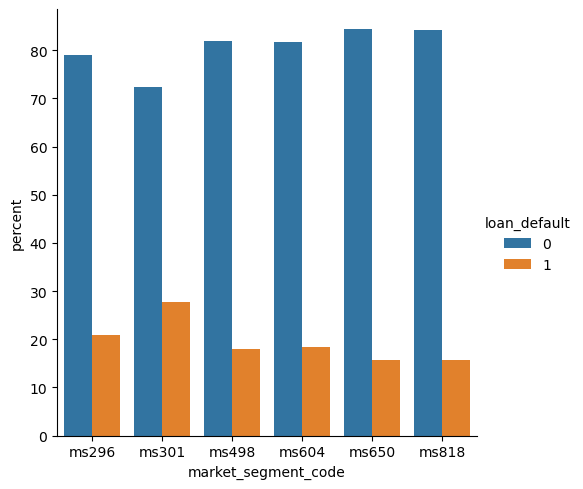

In [46]:
plot_categorical_vs_target(df,'market_segment_code','loan_default')

### market_segment_code
Much like loan_type, there are roughly equal proportions throughout the values for the market_segment_code, though the ms301 value has a slightly higher percentage of defaulters.

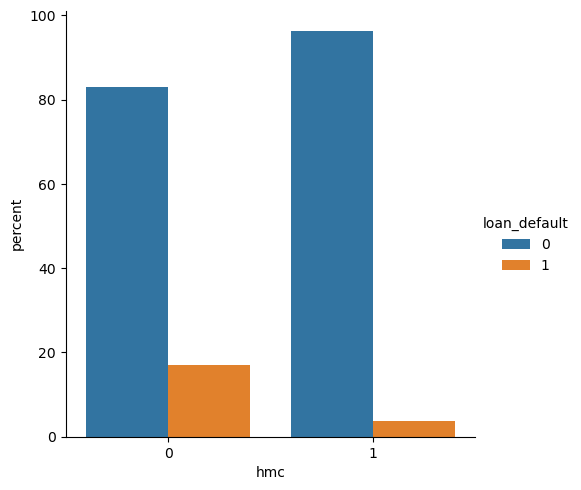

In [47]:
plot_categorical_vs_target(df,'hmc','loan_default')

### hmc
High maintenance customers have a much lower rate of default than regular customers.

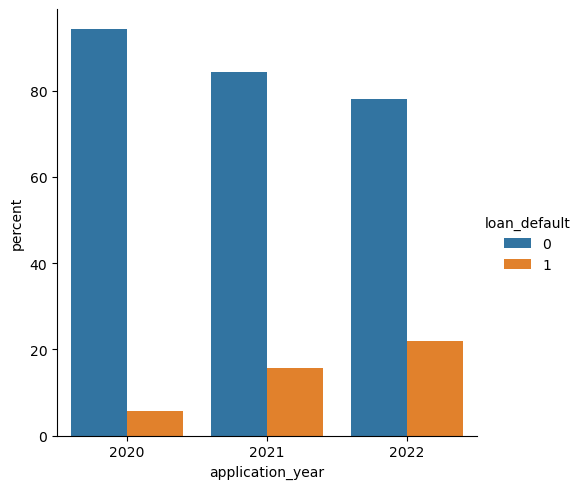

In [48]:
plot_categorical_vs_target(df,'application_year','loan_default')

### application_year
As the records get more recent, there is a higher proportion of people who default on their loans. 

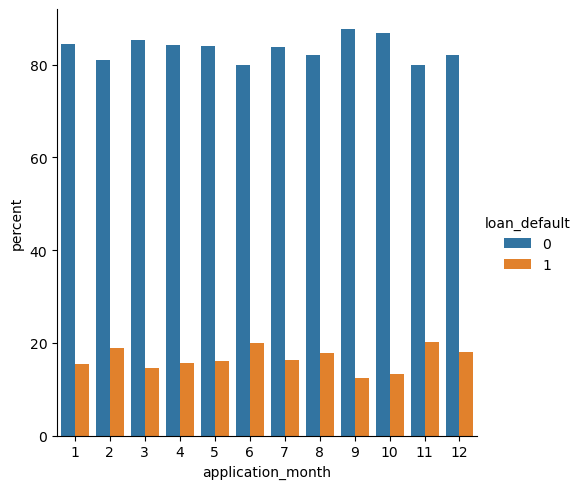

In [49]:
plot_categorical_vs_target(df,'application_month','loan_default')

### application_month
The proportion of defaulters is roughly equal regardless of the month.

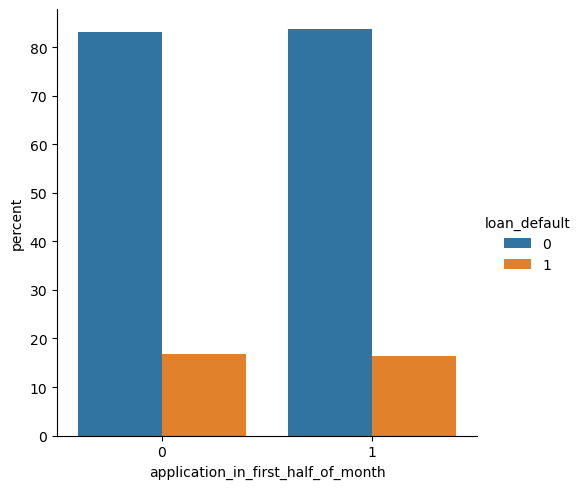

In [50]:
plot_categorical_vs_target(df,'application_in_first_half_of_month','loan_default')

### application_in_first_half_of_month
The proportion of defaulters is mostly the same regardless of whether the application was in the first or last half of the month.

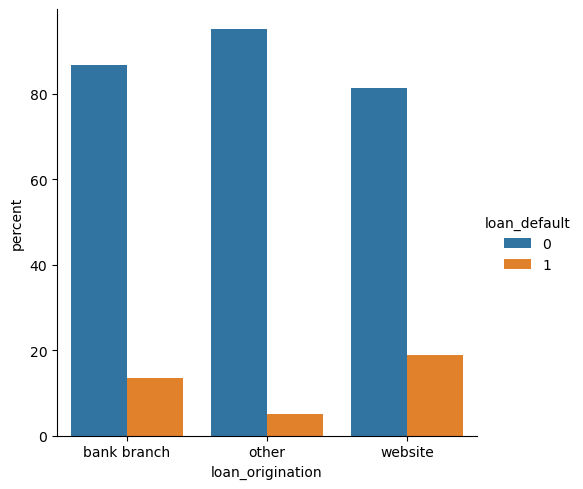

In [51]:
plot_categorical_vs_target(df,'loan_origination','loan_default')

### loan_origination
Loans that originate from other sources have a much lower rate of default than loans that originated from a bank branch or website.

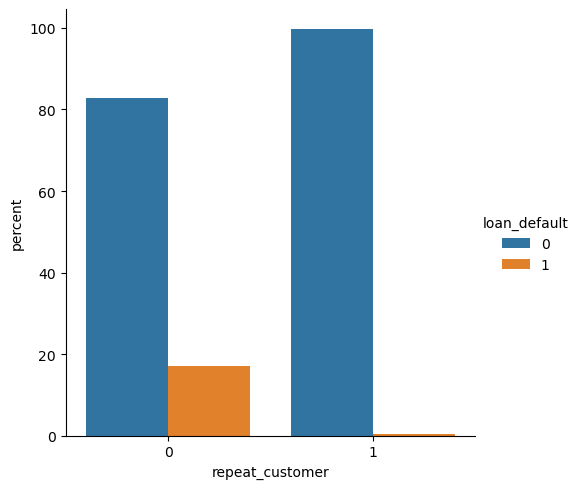

In [52]:
plot_categorical_vs_target(df,'repeat_customer','loan_default')

### repeat_customer
Repeat customers have a much lower rate of default than first-time customers.

We have just done bivariate EDA for each categorical variable with respect to the target variable.

# Extra Step: Additional EDA 

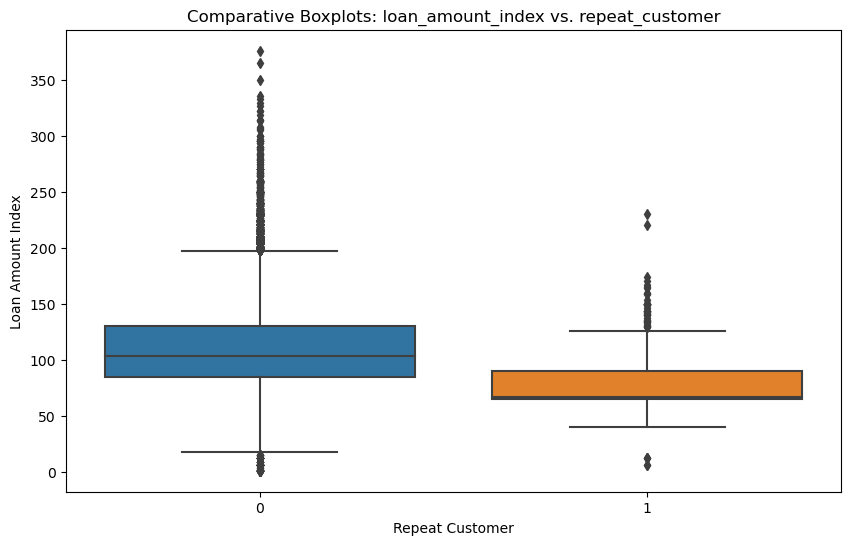

In [53]:
# Comparative boxplots using seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['repeat_customer'], y=df['loan_amount_index'])
plt.title('Comparative Boxplots: loan_amount_index vs. repeat_customer')
plt.xlabel('Repeat Customer')
plt.ylabel('Loan Amount Index')
plt.show()


### Loan Amount Index vs. Repeat Customer

New customers tend to have a higher loan amount index than repeat customers, and there are more outliers in the new customer group with higher loan amount indices.

# Step 16: Bivariate EDA of each quantitative variable with respect to target

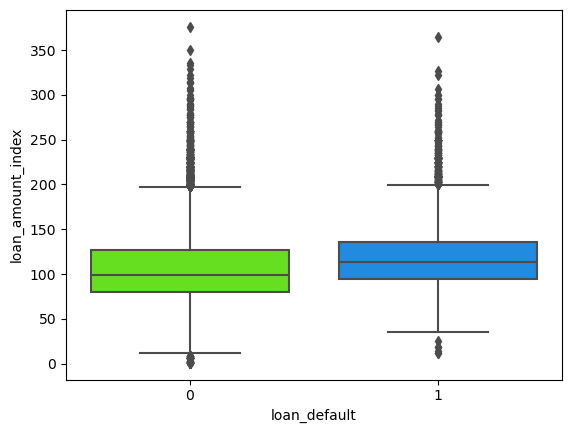

In [54]:
boxplots_vs_target(df,'loan_amount_index','loan_default')

### loan_amount_index
Slightly higher indices for the loan amount are associated with default on a loan.

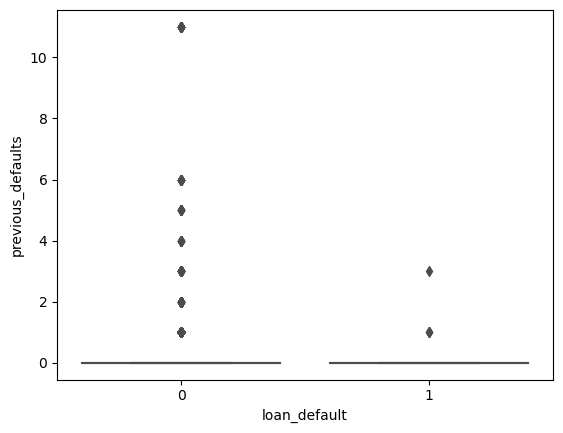

In [55]:
boxplots_vs_target(df,'previous_defaults','loan_default')

### previous_defaults
Based off the small number of outliers, people with more previous defaults do not default on a loan. However, the large majority of people have had 0 previous defaults which is not associated with whether they have or have not defaulted on this loan.

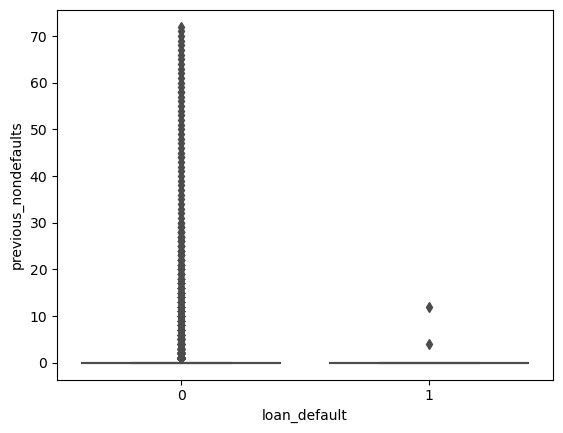

In [56]:
boxplots_vs_target(df,'previous_nondefaults','loan_default')

### previous_nondefaults
People with more previous nondefaults, or successful payment, have a lower rate of defaulting, though this is only based off of the outliers which, unlike the previous field, occur in a higher number. Most people have had 0 previous nondefaults, which is more associated neither with default nor with nondefault.

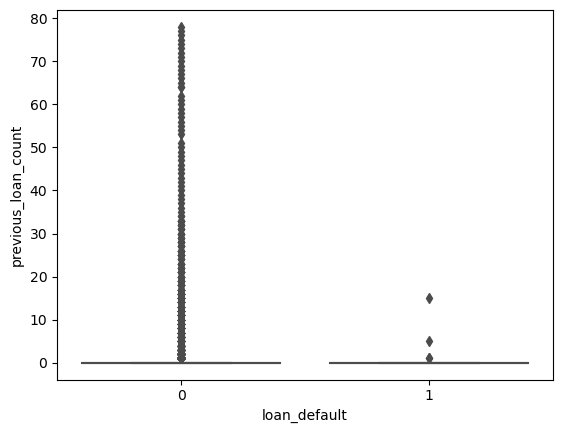

In [57]:
boxplots_vs_target(df,'previous_loan_count','loan_default')

### previous_loan_count
Based on the outliers, people who have taken out previous loans tend not to default. Most people have 0 previous loans which is not associated with whether a loan will be defaulted on or not.

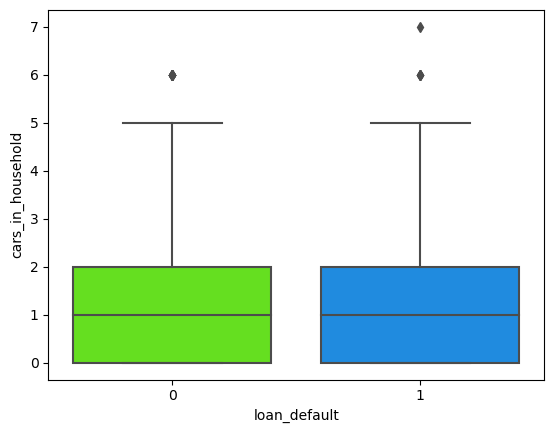

In [58]:
boxplots_vs_target(df,'cars_in_household','loan_default')

### cars_in_household
There is essentially no visible difference between the distribution of the number of cars in a household for performing loans compared to loans in default.

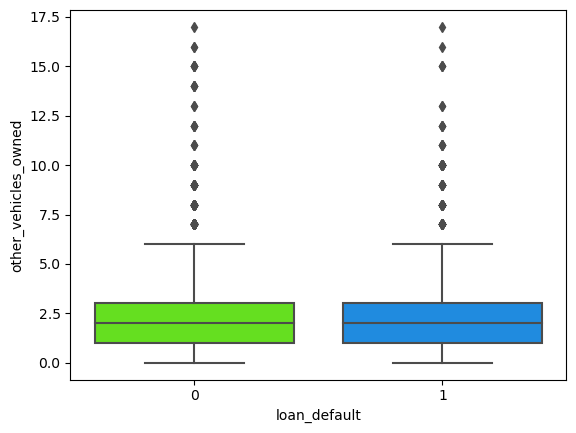

In [59]:
boxplots_vs_target(df,'other_vehicles_owned','loan_default')

### other_vehicles_owned
Like the cars_in_household field, there is no visible difference between the other_vehicles_owned distribution for performing loans compared to loans in default.

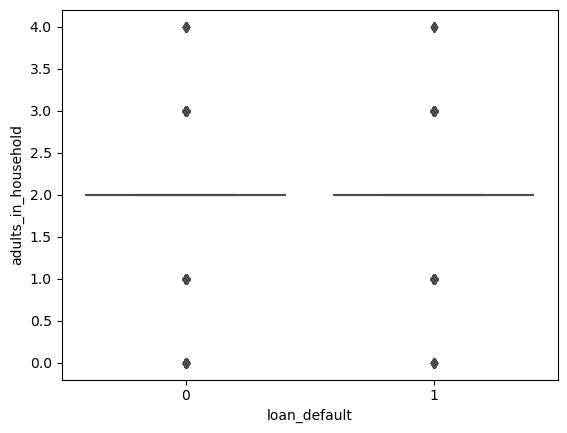

In [60]:
boxplots_vs_target(df,'adults_in_household','loan_default')

### adults_in_household
Most households have 2 adults, but this is not associated with whether a loan will be performing or defaulted on.

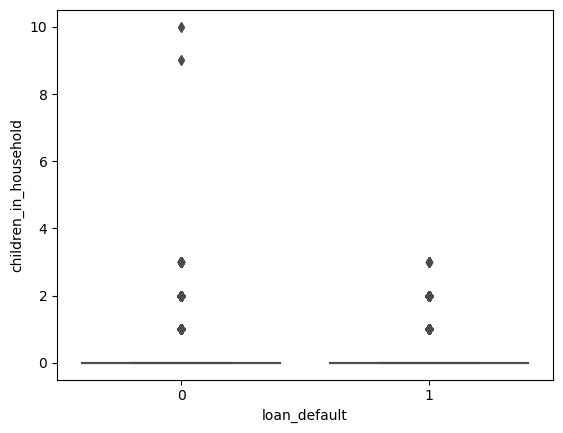

In [61]:
boxplots_vs_target(df,'children_in_household','loan_default')

### children_in_household
Most households have 0 children, but this is not associated with whether a loan will be performing or not. There are a few outliers with more than 8 children, who did not default on their loans.

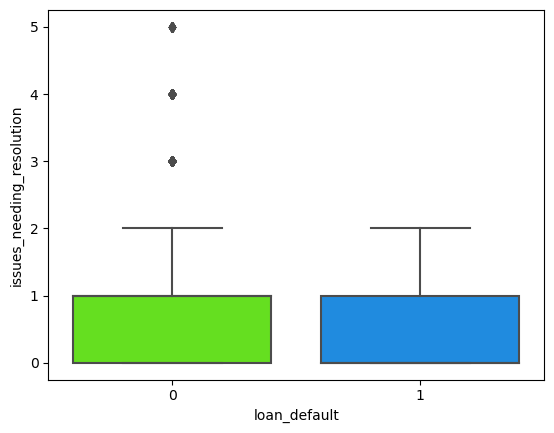

In [62]:
boxplots_vs_target(df,'issues_needing_resolution','loan_default')

### issues_needing_resolution
Aside from a few outliers that indicate customers who did not default with an unusually high number of issues needing resolutions, there is no visible difference between the distributions.

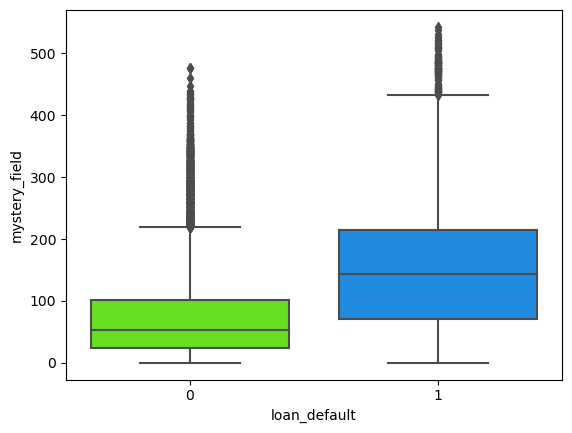

In [63]:
boxplots_vs_target(df,'mystery_field','loan_default')

### mystery_field
Higher values in the mystery_field are associated with loan default than with no loan defuault, but there are quite a bit of outliers in the mystery field for both the loan default and no default groups.

We have just done bivariate EDA for each quantitative variable with respect to the target variable.

# Step 17: Bivariate EDA of loan_amount_index with respect to market_segment_code

<Axes: xlabel='loan_amount_index', ylabel='market_segment_code'>

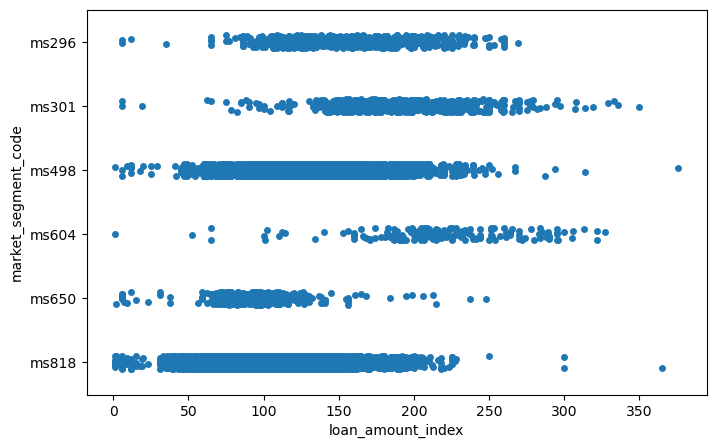

In [64]:
fig, ax = plt.subplots(figsize=(8,5))
sns.stripplot(x='loan_amount_index', y='market_segment_code', data=df)

This strip chart shows the distribution of the loan_amount_index for each value of the market_segment_code. 

We can see very few individual dots for the ms818 market segment, which means that there are a lot of loan applicants with that market segment code who are clustered around the loan amount index of 0-200. 

On the other hand, we are able to see a lot of individual dots for the ms604 market segment code because there are not a lot of applicants with that segment. Individuals with the ms604 market segment code have a higher loan amount index on average. 

<Axes: xlabel='loan_amount_index', ylabel='market_segment_code'>

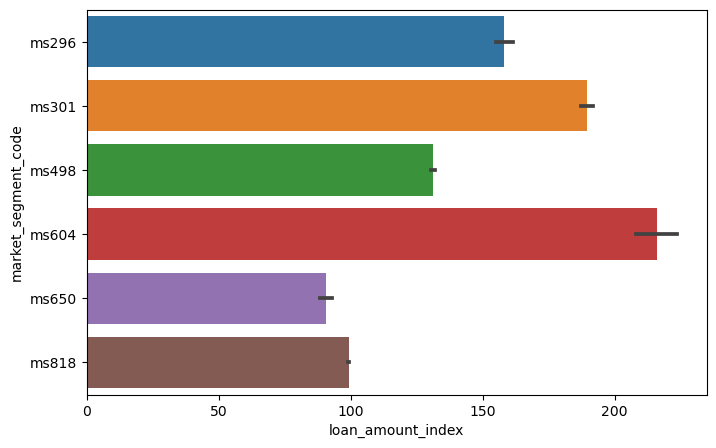

In [65]:
fig, ax = plt.subplots(figsize=(8,5))
sns.barplot(x='loan_amount_index', y='market_segment_code', data=df)

The horizontal black segment is so tiny for segment ms818 because of the high number of loan applicants with that segment. More data makes the 95% confidence interval more precise.

On the other hand, the ms604 95% confidence interval is so wide because there are not a lot of loan applicants with that segment, making the confidence interval much less precise.

The difference of about 30 units between the mean for ms604 and the mean for ms301 is statistically significant because their confidence intervals do not overlap, indicating that the difference between the measured counts is larger than the margin of sampling error.

We have just created and analyzed a strip chart and bar graph with confidence intervals for loan_amount_index vs. market_segment_code.

# Step 18: Bivariate Pearson heatmap

C:\Users\xstev\AppData\Local\Temp\ipykernel_11896\1534013660.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(method='pearson'), annot=True, vmin=-1, vmax=1, fmt='.2f', cmap='Spectral')


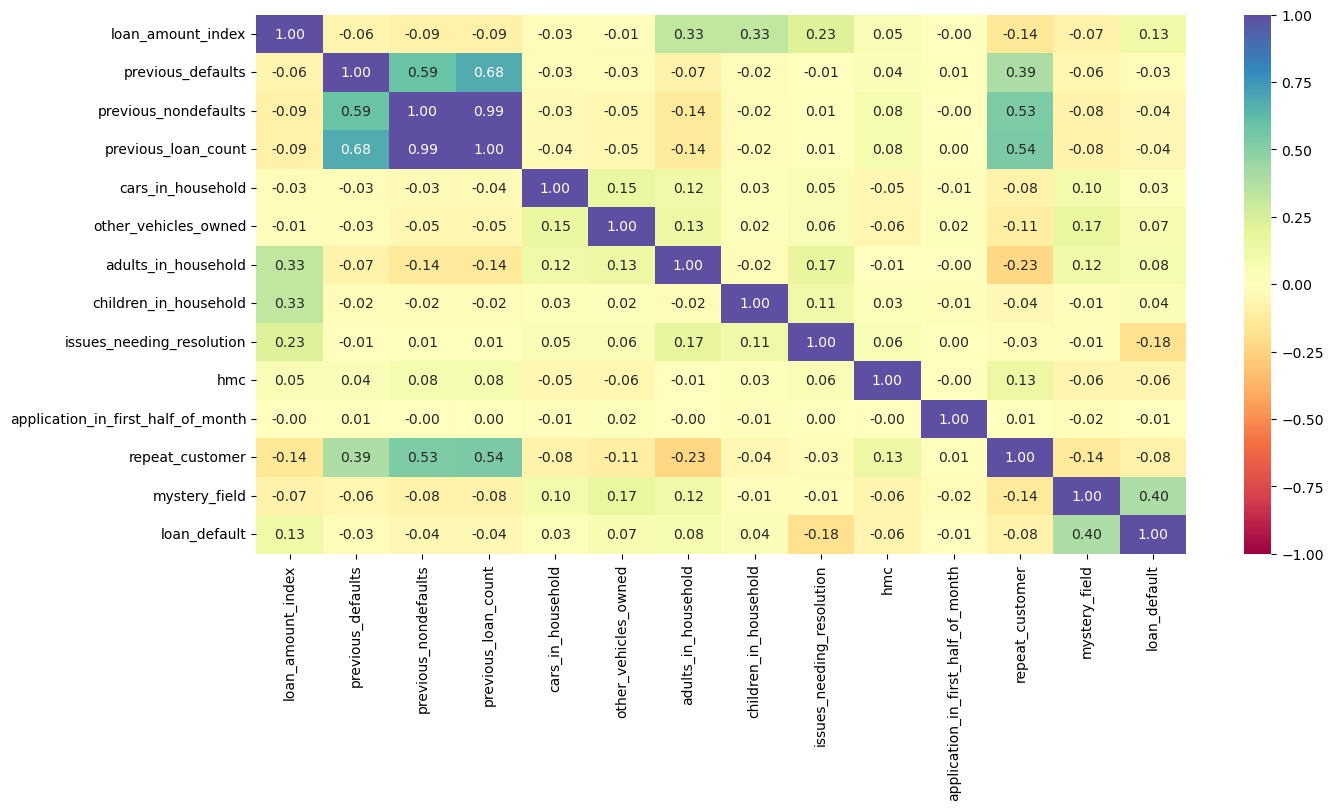

In [66]:
plt.figure(figsize=(15, 7))
sns.heatmap(df.corr(method='pearson'), annot=True, vmin=-1, vmax=1, fmt='.2f', cmap='Spectral')
plt.show()

* The previous_nondefaults and previous_loan_count fields are highly positively correlated, with an r value of 0.99. This makes sense when considering the fact that most first time customers, which make up almost all of the data set, will have taken out 0 loans and thus cannot have any non-defaults.


* The previous_defaults and previous_loan_count fields are somewhat positively correlated, with an r value of 0.68. This r value is likely lower than that between previous_nondefaults and previous_loan_count due to the fact that there are fewer customers who would have taken out a loan before and have a positive previous loan counts, so the LSRL for this minority group can be skewed by outliers with higher numbers of previous defaults. This is not the case for the large majority of people who have a previous loan count of 0.


* Interestingly, previous_defaults and previous_nondefaults are somewhat positively correlated, with an r value of 0.59. Since the majority of customers are new customers, they will have 0 previous defaults and 0 previous non-defaults, but the LSRL between these two variables will be affected by the roughly 3% of customers (which still amount to about 1180 customers) who have varying amounts of past defaults and non-defaults.


* Both the adults_in_household variable and the children_in_household variable are positively correlated with loan_amount_index, with an r value of 0.33. This makes sense when considering the fact that larger households will need bigger and often more expensive houses and cars, and auto and home loans make up over 80% of HansenBank loans. However, this is certainly not always the case, and circumstances for loan applications can vary quite a bit, which explains why the correlation is not close to 1.0.


* Whether or not a customer is a repeat customer is somewhat positively correlated with previous loan count, with an r value of 0.54. The large majority of customers are new, and these customers will always have a previous loan count of 0. However, the perfect correlation this relationship would produce is offset by the repeat customers who have varying numbers of previous loan counts.


* Similarly, whether or not a customer is a repeat customer is somewhat positively correlated with previous_nondefaults, with an r value of 0.53. Again, the large majority of customers, being new, will always have 0 nondefaults. Repeat customers affect the LSRL to produce a less strong correlation.


* Whether or not a customer is a repeat customer is somewhat positively correlated with previous_defaults, with an r value of 0.39. This is a weaker correlation than between repeat_customer and previous_nondefaults likely because it is less common to default on a loan, and values for number of defaults are, on average, lower than number of nondefaults, as seen in the EDA. This means the small pool of data points with previous defaults will skew the LSRL more and make the fit weaker.


* The only variable that has a correlation coefficient of note with the target variable is the mystery_field, which suggests this variable could be particularly important in the construction of our model.

We have just created and analyzed a Pearson's correlation heatmap for the data.

# Step 19: Bivariate Spearman heatmap

C:\Users\xstev\AppData\Local\Temp\ipykernel_11896\285283417.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(method='spearman'), annot=True, vmin=-1, vmax=1, fmt='.2f', cmap='Spectral')


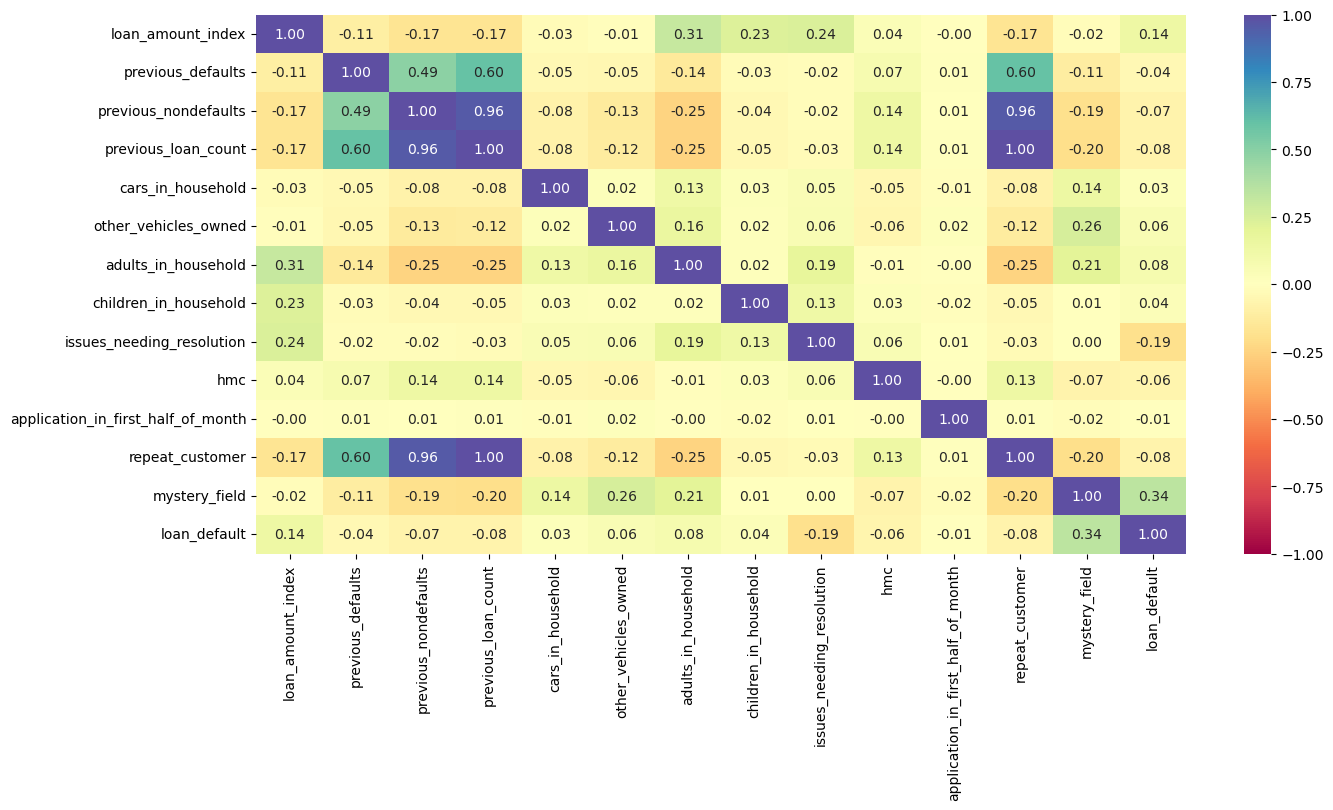

In [67]:
plt.figure(figsize=(15, 7))
sns.heatmap(df.corr(method='spearman'), annot=True, vmin=-1, vmax=1, fmt='.2f', cmap='Spectral')
plt.show()

Relationships between variables are largely the same as in step 18, with a few notable exceptions, listed below.

* The correlation between the repeat_customer and previous_nondefaults variables is much higher, with a Spearman's correlation coefficient of 0.96. This suggests that whether or not someone is a repeat customer almost perfectly predicts their number of previous nondefaults. This makes sense given that the large majority of the dataset, which are new customers, are guaranteed to have 0 previous nondefaults.


* The correlation between the repeat customer and previous_loan_count is a 1.0 correlation, which in the case of Spearman's rho, indicates that the previous_loan_count variable always increases as the repeat_customer variable increases. This makes sense because the definition of a repeat customer is one that has a non-zero loan count.


The important difference to consider between this step and step 18 is that the Spearman's rho looks at strength and direction simply of monotonic correlation; in other words, the extent to which one variable consistently increases or decreases with another.

We have just created and analyzed a Spearman's correlation heatmap for the data.

# Step 20: Multivariate EDA

Top graph: loan_type == 'auto'
Bottom graph: loan_type == 'residential'


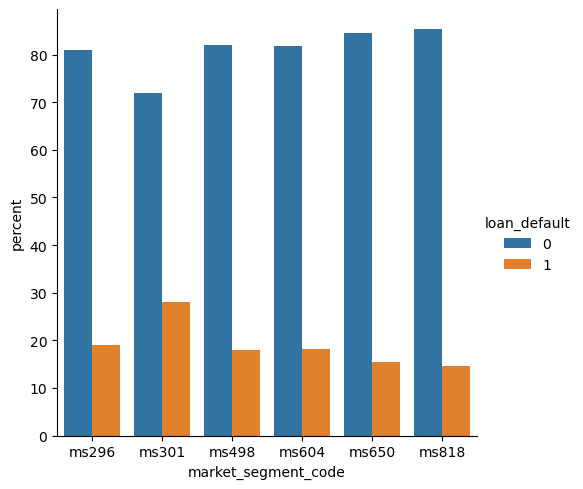

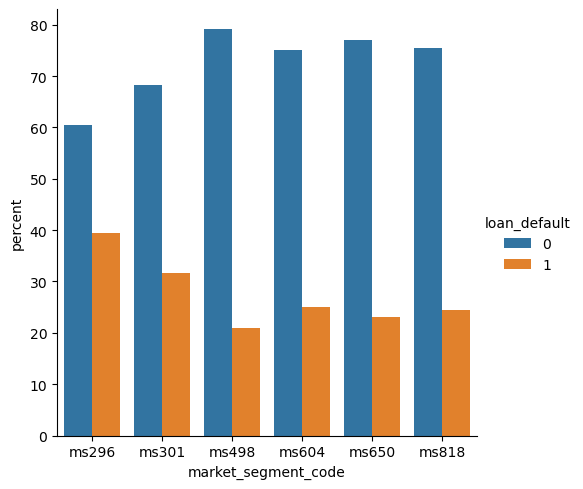

In [68]:
print("Top graph: loan_type == 'auto'")
print("Bottom graph: loan_type == 'residential'")
x,y = 'market_segment_code', 'loan_default'
for feature in [df[df['loan_type']=='auto'],
 df[df['loan_type']=='residential'],
 ]:
 (feature
 .groupby(x)[y]
 .value_counts(normalize=True)
 .mul(100)
 .rename('percent')
 .reset_index()
 .pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar'))
 plt.show()

* For auto loans, market segment 301 has the highest default rate of just under 30%.


* For residential loans, market segment 296 has the highest default rate of just under 40%.


* It is not surprising that default rate profiles change as loan type changes, specifically that default rates increase for each market segment for residential loans compared to auto loans. Residential loans tend to be more expensive than auto loans, making them harder to pay off and easier to default on.

We have just investigated the multivariate interaction between loan_type, market_segment_code, and the target variable, loan_default.

# Step 21: Create dummy variables in explanatory matrix

In [69]:
X = df.drop(['loan_default'], axis=1)
y = df['loan_default']
X = sm.add_constant(X) # This step is essential for the statsmodels library (not for sklearn).
X = pd.get_dummies(X, drop_first=True)

We have just created dummy variables and constructed an explanatory matrix and target column for our regression (X and y, respectively).

# Step 22: Split into train and test sets

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=926)
old_row_count = X_train.shape[0]

In [71]:
print("Number of rows in X_train: ", X_train.shape[0])
print("Number of rows in X_test: ", X_test.shape[0])
print("Proportion of data that is test: ", X_test.shape[0]/(X_train.shape[0]+X_test.shape[0]))

Number of rows in X_train:  27682
Number of rows in X_test:  11864
Proportion of data that is test:  0.3000050574015071


The split between training and test data was made correctly, since the counts indicate that 30% of the observations are in the test subset, as intended.

We have just split the data into train and test sets.

# Step 23: Resolve multicollinearity issues in X_train

In [72]:
calculate_vif(X_train)

C:\Users\xstev\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,column name,VIF
0,const,129.818556
1,loan_amount_index,2.156546
2,previous_defaults,inf
3,previous_nondefaults,inf
4,previous_loan_count,inf
5,cars_in_household,1.064534
6,other_vehicles_owned,1.098678
7,adults_in_household,1.401263
8,children_in_household,1.877903
9,issues_needing_resolution,1.223135


The columns previous_defaults, previous_nondefaults, previous_loan_count, market_segment_code_ms498, and market_segment_code_ms818 all have VIFs of above 5, with the first three having VIFs of infinity. This makes sense in context of some of the analysis from steps 18 and 19-- given that a previous loan count of 0 automatically yields 0 previous defaults and 0 previous nondefaults, and that the majority of observations are new customers with a loan count of 0, we can expect previous defaults and nondefaults to be highly correlated to previous loan count, as observed both in their VIF values and in the Pearson and Spearman heatmaps.

In [73]:
X_train = X_train.drop(['previous_defaults','previous_nondefaults', 'previous_loan_count', 'market_segment_code_ms498', 'market_segment_code_ms818'], axis=1)
calculate_vif(X_train)

,column name,VIF
0,const,46.652932
1,loan_amount_index,1.953614
2,cars_in_household,1.063054
3,other_vehicles_owned,1.090426
4,adults_in_household,1.342797
5,children_in_household,1.869754
6,issues_needing_resolution,1.218501
7,hmc,1.046197
8,application_in_first_half_of_month,1.003109
9,repeat_customer,1.427825


The VIF values for all the columns except for the const column are now under 5.

We have just removed multicollinearity from our training dataset.

# Step 24: Drop same set of columns from X_test

In [74]:
X_test = X_test.drop(['previous_defaults','previous_nondefaults', 'previous_loan_count', 'market_segment_code_ms498', 'market_segment_code_ms818'], axis=1)

We have just dropped the same set of columns as in step 23 from the test dataset. We are doing so separately from the training dataset so that our VIF analyses are only based on the training data, to make sure only the training dataset informs our model construction and avoid information leakage.

# Step 25: Rebalance the training data

In [75]:
X_rebuilt = pd.concat([X_train, y_train], axis = 1)
df_bad = X_rebuilt[X_rebuilt['loan_default'] == 1]
X_balanced = pd.concat([X_rebuilt, df_bad, df_bad, df_bad, df_bad]) # 4 more copies of bad loans
X_balanced.describe().T

,count,mean,std,min,25%,50%,75%,max
const,45794.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
loan_amount_index,45794.0,112.852906,36.795013,1.0,88.0,107.0,131.0,376.0
cars_in_household,45794.0,0.867712,0.880527,0.0,0.0,1.0,2.0,6.0
other_vehicles_owned,45794.0,2.303708,1.449354,0.0,1.0,2.0,3.0,16.0
adults_in_household,45794.0,1.904726,0.514488,0.0,2.0,2.0,2.0,4.0
children_in_household,45794.0,0.123706,0.427430,0.0,0.0,0.0,0.0,10.0
issues_needing_resolution,45794.0,0.633707,0.789895,0.0,0.0,0.0,1.0,5.0
hmc,45794.0,0.022951,0.149748,0.0,0.0,0.0,0.0,1.0
application_in_first_half_of_month,45794.0,0.491396,0.499931,0.0,0.0,0.0,1.0,1.0
repeat_customer,45794.0,0.018168,0.133561,0.0,0.0,0.0,0.0,1.0


The mean of the loan_default column is close to 0.5, indicating that the dataset is properly balanced.

In [76]:
# Rebuild X_train and y_train from the rebalanced data
X_train = X_balanced.drop(['loan_default'], axis=1)
y_train = X_balanced['loan_default']

In [77]:
# Count number of loans that ended in default in original X_train
row_count = X_rebuilt[X_rebuilt['loan_default'] == 1].shape[0]
print(row_count)

4528


In [78]:
# Check that original number of 'bad' loans multiplied by four and
# added to the original X_train row count equals the new X_train
# and y_train row counts
print('Target row count = ', row_count*4 + old_row_count)
print('X_train row count = ', X_train.shape[0])
print('y_train row count = ', y_train.shape[0])

Target row count =  45794
X_train row count =  45794
y_train row count =  45794


We have just balanced the training data set, verifying our work to ensure the balancing was performed correctly.

# Step 26: Make first regression attempt

In [79]:
attempt_1 = sm.Logit(y_train, X_train.astype(float))
fit_1 = attempt_1.fit(
 disp=True
) # setting disp=False will remove the information on number of iterations
print(fit_1.summary())

Optimization terminated successfully.
         Current function value: 0.461049
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:           loan_default   No. Observations:                45794
Model:                          Logit   Df Residuals:                    45763
Method:                           MLE   Df Model:                           30
Date:                Wed, 13 Dec 2023   Pseudo R-squ.:                  0.3348
Time:                        14:28:25   Log-Likelihood:                -21113.
converged:                       True   LL-Null:                       -31739.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                 -4.4422      0.091    

The regression fit with a pseudo R^2 value of 0.3348 is not ideal. Only about 33% of variation in the target variable can be explained by the current model.

The application_in_first_half_of_month, loan_type_residential, application_month_7, application_month_8, application_month_10, application_month_11, and application_month_12 coefficients all have p-values greater than 0.05, indicating a lack of statistical significance.   

We have just made and analyzed an initial regression attempt.

# Step 27: Remove extraneous variables

In [80]:
# initial list of columns
cols = X_train.columns.tolist() # modified slightly from original version (author unknown)
# setting an initial max p-value
max_p_value = 1
while len(cols) > 0:
 # defining the train set
 X_train_aux = X_train[cols] # another slight modification in this line . . .
 # fitting the model
 model = sm.Logit(y_train, X_train_aux).fit(disp=False)
 # getting the p-values and the maximum p-value
 p_values = model.pvalues
 max_p_value = max(p_values)
 # name of the variable with maximum p-value
 feature_with_p_max = p_values.idxmax()
 if max_p_value >= 0.05: # using standard threshold for significance
     cols.remove(feature_with_p_max)
 else:
     break
selected_features = cols
print(selected_features)

['const', 'loan_amount_index', 'cars_in_household', 'other_vehicles_owned', 'adults_in_household', 'children_in_household', 'issues_needing_resolution', 'hmc', 'repeat_customer', 'mystery_field', 'loan_type_other', 'market_segment_code_ms301', 'market_segment_code_ms604', 'market_segment_code_ms650', 'application_year_2021', 'application_year_2022', 'application_month_2', 'application_month_3', 'application_month_4', 'application_month_5', 'application_month_6', 'application_month_9', 'loan_origination_other', 'loan_origination_website']


In [81]:
print(X_train.shape) # initial training data dimensions
X_train = X_train_aux
X_train.shape

(45794, 31)


(45794, 24)

We have just removed extraneous variables and verified that our new X_train dataframe has the same number of rows (43794), but 7 fewer columns.

# Step 28: Make second regression attempt

In [82]:
attempt_2 = sm.Logit(y_train, X_train.astype(float))
fit_2 = attempt_2.fit(
 disp=True
) # setting disp=False will remove the information on number of iterations
print(fit_2.summary())

Optimization terminated successfully.
         Current function value: 0.461143
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:           loan_default   No. Observations:                45794
Model:                          Logit   Df Residuals:                    45770
Method:                           MLE   Df Model:                           23
Date:                Wed, 13 Dec 2023   Pseudo R-squ.:                  0.3347
Time:                        14:28:26   Log-Likelihood:                -21118.
converged:                       True   LL-Null:                       -31739.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -4.4481      0.078    -56.825      0.000      -4.

All the p-values are now less than 0.05, indicating that all the coefficients are statistically significant. However, the pseudo R-squared value is slightly lower at 0.3347, which is not ideal.

We have just made and analyzed a second regression attempt.

# Step 29: Evaluate model performance (train)

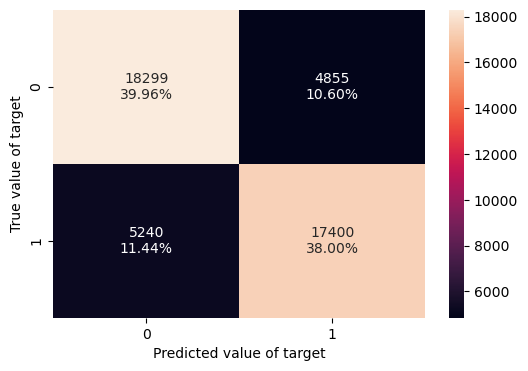

In [83]:
confusion_matrix_statsmodels(fit_2, X_train, y_train)

The classes in the confusion matrix appear well balanced, with about 38% and 40% of values being true positives and true negatives, respectively, and 11% and 11% of values being false positives and false negatives, respectively.

The accuracy of the model is $\frac{(TP + TN)}{\text{total number of records}} = \frac{17400 + 18299}{\text{18299 + 4855 + 5240 + 17400}} = \frac{17400 + 18299}{\text{45794}} = 0.78$, which is good, but not ideal.

In [84]:
# Compute important metrics from confusion matrix
log_reg_model_train_perf = model_performance_classification_statsmodels(
 fit_2, X_train, y_train
)
print("Training performance:")
log_reg_model_train_perf

Training performance:


,Accuracy,Recall,Precision,F1
0,0.779556,0.768551,0.781847,0.775142


The recall indicates what proportion of customers who defaulted on their loans were predicted correctly to do so by the model, which in this case was 77.86%. The precision indicates what proportion of customers predicted to default on loans actually defaulted, which in this case was 78.18%, very similar to the recall.

We have just evaluated the model's performance on the training data.

# Step 30: Evaluate model performance (test)

In [85]:
X_test = X_test[selected_features]

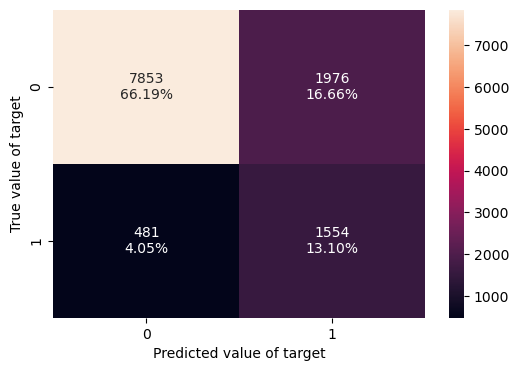

In [86]:
confusion_matrix_statsmodels(fit_2, X_test, y_test)

In [87]:
log_reg_model_test_perf = model_performance_classification_statsmodels(
 fit_2, X_test, y_test
)
print("Training performance:")
log_reg_model_test_perf

Training performance:


,Accuracy,Recall,Precision,F1
0,0.792903,0.763636,0.440227,0.558491


The accuracy of 79.29% and recall of 76.36% are comparable to that of the model's performance on the training data; however, the precision (44.02%) and F1 (55.85%) are quite a bit lower than the same metrics in step 29. This indicates overfitting of the model on the training data when it comes to precision and the F1 metrics, as the model becomes less able to correctly predict the positive class on new data.

We have just evaluated the model's performance on the test data.

# Step 31: Overall model evaluation

This model is good enough for predicting loan defaults, though it is certainly not the best. Although overfitting did occur in the Precision and F1 metrics, the Recall and Accuracy metrics are at an acceptable percentage, which are the metrics we had planned to emphasize in step 2 for optimal profitability loan predictions.

We have just evaluated the overall model.

# Step 32: Limitations and ethical concerns

##### Q1. The data are all recent, from approximately the past 3 years. As a result, many of the loans in the dataset are still in the process of being repaid by customers. Is there any potential bias in the model that we should be concerned about?

There may be a possibility that a good number of the loans that are still being repaid may be defaulted on later down the line. As a result, the model may not detect some statistics that indicate a loan may be defaulted on later, and inaccurately say a loan with those statistics will not be defaulted on.

##### Q2. Is there any PII in the notebook that should be redacted or blurred? Pay special attention to the bivariate graphs that show loan status with outliers that might be easily linked to specific bank customers.

There may be PII in the outliers of the bivariate graphs of loan_amount_index, previous_defaults, previous_nondefaults, previous_loan_count, cars_in_household, other_vehicles_owned, children_in_household, and issues_needing_resolution with respect to the target variable. Many of these have outliers that are more or less separated from the boxplots and the rest of the outliers, which means they are unique loan applicants who may be personally identified.


##### Q3. Do you have any legal or ethical concerns about using mystery_field as one of the explanatory variables? Explain what some of the issues might be.

Due to the mystery_field's lack of transparency, it is very likely that the data may cause legal or ethical concerns that the one who blurred it may not want to be revealed. The field may be based on metrics related to race, gender, or other qualities that may make the model discriminate against specific groups of people. The person who has to decide whether or not to implement the model will not know whether the field can introduce bias or cause other legal problems for the bank.  

We have just discussed the model's limitations and ethical concerns.

# Step 33: Estimate the value of the model (with assumptions documented)

### Assumptions

* We will take performance statistics from test data in step 30.
* We will treat the model as valid throughout the entire lifetime of each loan.
* Bank officers do not change their approval criteria after the predictive model is put into production.
* The default rate for loans that are able to pass the bank officers’ initial approval process is 16.6%.
* Each performing loan nets the bank a mean profit of $\$$3500.
* Each loan that goes into default costs the bank a mean of $\$$15,000

### Status Quo Net Profit

There are a hypothetical 40,000 loan applications that the loan officers all approved. The default rate for the approved loans is 16.6%.

40,000 $\cdot$ 0.166 $=$ 6,640 defaulted

40,000 $-$ 6640 $=$ 33,360 nondefaulted

Gross Loss $=$ 6,640 $\cdot$ $\$$15,000 $=$ $\$$99,600,000

Gross Profit $=$ 33,360 $\cdot$ $\$$3,500 $=$ $\$$116,760,000

Net profit $=$ $\$$116,760,000 $-$ $\$$99,600,000 $=$ $\$$17,160,000

### Model Profit

##### Confusion Matrix Approach

We directly used the percentages from the confusion matrix of step 30 to calculate the TP, FN, TN, and FP of the model for the hypothetical 40,000 loan applications. Then, similar to the calculations for the status quo net profit, we calculated the net profit as well.

In [88]:
from IPython.display import display, HTML, IFrame

# Replace 'your_file.pdf' with the actual file path
pdf_path = 'Confusion Matrix Approach.png'

# Use IFrame to embed the PDF in an HTML page
pdf_embed = IFrame(src=pdf_path, width="100%", height=450)

# Display the embedded PDF
display(pdf_embed)

The net profit is $\$$68,366,000.

$\$$68,366,000 $-$ $\$$17,160,000 $=$ $\$$51,206,000 more profit

##### Recall and Precision Approach Using Net Profit

We directly used the recall and precision statistics of step 30 to calculate the TP and FP, which would then allow us to find the FN and the TN to make our calculations for the net profit. We used the recall and precision statistics on the status quo distribution of the 40,000 loans. We did not make a new distribution for the loans based on our confusion matrix percentages like in the previous approach.

In [89]:
from IPython.display import display, HTML, IFrame

# Replace 'your_file.pdf' with the actual file path
pdf_path = 'Recall and Precision Approach.png'

# Use IFrame to embed the PDF in an HTML page
pdf_embed = IFrame(src=pdf_path, width="100%", height=400)

# Display the embedded PDF
display(pdf_embed)

The net profit is $\$$70,657,000

$\$$70,657,000 $-$ $\$$17,160,000 $=$ $\$$53,497,000 more profit

##### An Alternative Approach Using Recall and Precision

In [90]:
from IPython.display import display, HTML, IFrame

# Replace 'your_file.pdf' with the actual file path
pdf_path = 'RecallandPrecisionMethod2.png'

# Use IFrame to embed the PDF in an HTML page
pdf_embed = IFrame(src=pdf_path, width="100%", height=400)

# Display the embedded PDF
display(pdf_embed)

The amount of money saved is $\$$38,354,578

Our third approach, using recall and precision metrics from the test data as outlined above, shows that our model would save HansenBank around 40 million dollars compared to the status quo.

Although the three approaches gave different numbers, overall, using our model as a secondary screening would make the bank many tens of millions of dollars more profit than the loan officers' criteria.

##### Computing Net Profit if Our Model Were Used As the Initial Loan Screening Tool

In [91]:
from IPython.display import display, HTML, IFrame

# Replace 'your_file.pdf' with the actual file path
pdf_path = 'Recall and Precision2.png'

# Use IFrame to embed the PDF in an HTML page
pdf_embed = IFrame(src=pdf_path, width="100%", height=500)

# Display the embedded PDF
display(pdf_embed)

$2306$ $*$ $\$$15,000 = $\$$34,590,000

$37694$ $*$ $\$$3,500 = $\$$131,929,000

Net profit = $\$$131,929,000 - $\$$34,590,000 = $\$$97,339,000

$\$$97,339,000 $-$ $\$$17,160,000 = $\$$80,179,000

Using our model as an initial screening would make HansenBank over $\$$80,000,000 more than the status quo profit.

# Step 34: Recommendations

Based on some of the data and observations we have made, as well as on additional research on credit, we make the below recommendations to improve the profitability of HansenBank’s loan department. 

* Based on the univariate EDA of application month in step 12, there seems to be fewer loan applications in the last 4 months of the year. If HansenBank implements a well placed marketing campaign right before September, the number of loan applications could increase during that time, which would improve profitability as well. 
* The bivariate EDA of loan_type with respect to loan_default in step 15 shows that residential loan types have a higher proportion of defaulting. Our team would be happy to work with you again to develop a model that would help HansenBank achieve a better balance in the number of residential loans approved so as to optimize profit given their high risk, high reward nature. 
* The bivariate EDA of loan_amount_index with respect to market_segment_code in step 17 shows that the ms604 segment has the highest average index. If HansenBank can implement a marketing campaign targeting this group, or the staff makes sure to make them as comfortable as possible, the bank could increase these types of applications and make more profit from these loans. Any possible defaulters would have a good chance of being caught by our model.
* Based on the bivariate EDA of repeat_customer with respect to loan_default in step 15, repeat customers have a vastly decreased probability of defaulting on their loans. HansenBank could implement benefits for repeat customers, such as lower interest rates on their loans or higher interest rates for their bank accounts to attract more applications from this group. 
* However, based on the bivariate relationship between repeat_customer and loan_amount_index in the additional EDA section after step 15, repeat customers also tend to have lower loan amounts. While retaining repeat customers is a priority, as outlined above, we encourage HansenBank to also implement a marketing campaign targeting new customers with the long-term goal of retention, perhaps by advertising the benefits for repeat customers outlined above.
* Finally, though we have put extensive thought into our recommendations based on our analyses of the data, we would like to encourage HansenBank to exercise care when using some of the metrics above and from the dataset to approve and deny loans. By the Equal Credit Opportunity Act, it is illegal to approve/deny loans based on marital status, age, or whether the applicant has in good faith acted on one of their rights under federal credit laws. As such, factors like number of children, which in some geographic areas is highly correlated with marital status and can indicate age, or the fact that a customer is high maintenance, which may be due an extreme assiduity in disputing their credit score, must be used carefully so as to avoid lawsuits and ensure fairness under federal credit laws.


# Step 35: Add roc_auc_score and roc_curve to imports from sklearn.metrics

Done.

# Step 36: Plot ROC curve for training data, and compute ROC AUC

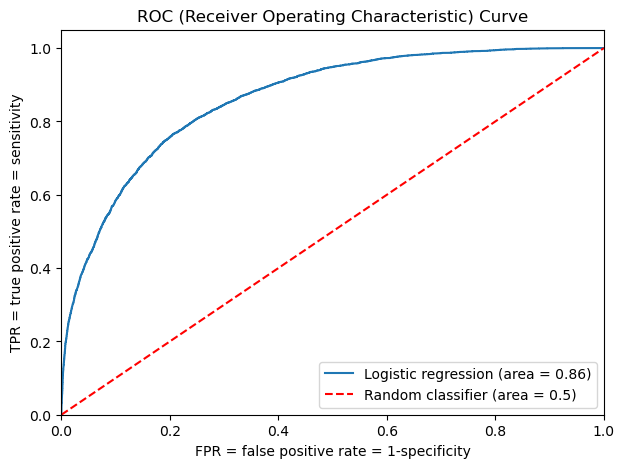

In [92]:
# Slightly modified version of ROC AUC plotting utility, original author unknown
logit_roc_auc_train = roc_auc_score(y_train, fit_2.predict(X_train))
fpr, tpr, thresholds = roc_curve(y_train, fit_2.predict(X_train))
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label="Logistic regression (area = %0.2f)" % logit_roc_auc_train)
plt.plot([0, 1], [0, 1], "r--", label="Random classifier (area = 0.5)")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("FPR = false positive rate = 1-specificity")
plt.ylabel("TPR = true positive rate = sensitivity")
plt.title("ROC (Receiver Operating Characteristic) Curve")
plt.legend(loc="lower right")
plt.show()

The logistic classifier we developed as our second fit is significantly better than a random classifier. The value of the ROC AUC is 0.86, which is generally considered to be excellent.

Source: https://www.statology.org/what-is-a-good-auc-score/

# Step 37: Find cutoff (classification threshold) that maximizes TPR – FPR

In [95]:
# Slightly modified version of code for finding optimal cutoff
# Original author unknown
fpr, tpr, thresholds = roc_curve(y_train, fit_2.predict(X_train))
optimal_idx = np.argmax(tpr - fpr)
print(thresholds[optimal_idx])
ideal = thresholds[optimal_idx]

0.504817766197688


The optimal threshold of 0.504817766197688 is not that much different from the default threshold of 0.5.

# Step 38: Evaluate model performance with optimal threshold (train)

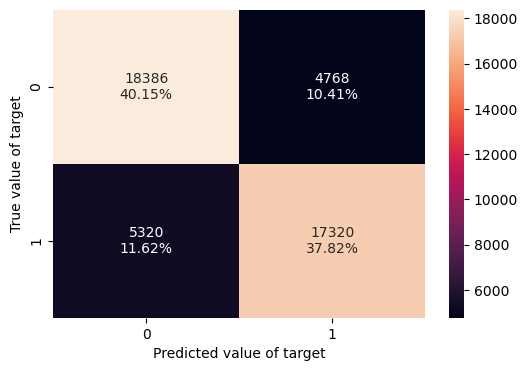

In [97]:
confusion_matrix_statsmodels(fit_2, X_train, y_train, threshold = ideal)

In [98]:
# Compute important metrics from confusion matrix
log_reg_model_train_perf = model_performance_classification_statsmodels(
 fit_2, X_train, y_train, threshold = ideal
)
print("Training performance:")
log_reg_model_train_perf

Training performance:


,Accuracy,Recall,Precision,F1
0,0.779709,0.765018,0.784136,0.774459


The original performance metrics were
* Accuracy at 0.779556
* Recall at 0.768551
* Precision at 0.781847
* F1 at 0.775142


The accuracy decreased by a negligible amount. The recall increased by a very small amount while the precision decreased by a very small amount. The F1 increased by a very small amount as well.

Overall, our new performance metrics have remained essentially the same. Using the optimal threshold would not improve the quality of our classification model. 

# Step 39: Evaluate model performance with optimal threshold (test)

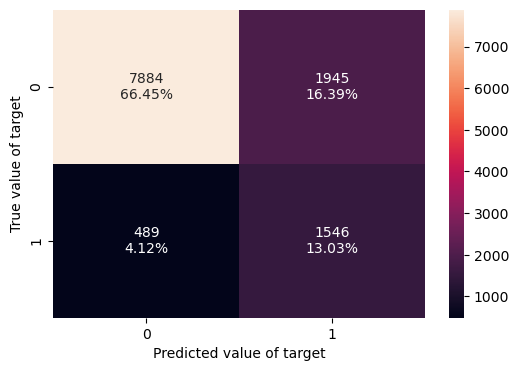

In [99]:
confusion_matrix_statsmodels(fit_2, X_test, y_test, threshold = ideal)

In [100]:
# Compute important metrics from confusion matrix
log_reg_model_test_perf = model_performance_classification_statsmodels(
 fit_2, X_test, y_test, threshold = ideal
)
print("Training performance:")
log_reg_model_test_perf

Training performance:


,Accuracy,Recall,Precision,F1
0,0.794842,0.759705,0.442853,0.559537
